In [13]:
import os
os.chdir(os.path.expanduser('~/RevisitingMGARinMWDisks/'))

# package import

In [14]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.dpi']=200
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

import pandas as pd
from astropy.table import Table
from scipy.stats import binned_statistic_2d, binned_statistic
from scipy.odr import ODR, Model, Data, RealData
import pymc as pm
import arviz as az

# parameters and functions

In [15]:
font = {'size':15}
font1 = {'size':20,'fontweight':'bold','color':'red'}
font2 = {'size':20,'fontweight':'bold'}
title_font={'fontsize':15,'fontweight':'bold'}
label_font={'fontsize':12}
temp_fontdict = {"fontsize": 18}
grad_label= r'$\mathrm{d[Fe/H]}/\mathrm{d}R_\mathrm{g}\,[\mathrm{dex \cdot kpc^{-1}}]$'
age_label = r'Age [$\mathrm{Gyr}$]'
rg_label = r'$R_\mathrm{g}\,[\mathrm{kpc}]$'
zmax_label = r'$Z_\mathrm{max}\,[\mathrm{kpc}]$'
feh_label = r'$\mathrm{[Fe/H]\,[dex]}$'
afe_label = r'$[\alpha/\mathrm{Fe}]\,[\mathrm{dex}]$'
three_age_labels=['young','intermediate','old']

def hist2d(fig,ax,xdata,ydata,zdata,stat='count',lognorm=False,vmin=1,vmax=1e4,xbin=100,ybin=100,cmap='viridis',cbar=False,*args,**kwargs):
    '''
    ax
    xdata
    ydata
    zdata
    stat='count'
    '''
    if 'xmin' and 'ymin' and 'xmax' and 'ymax' in kwargs.keys():
        xedges = np.linspace(kwargs['xmin'], kwargs['xmax'], xbin+1)
        yedges = np.linspace(kwargs['ymin'], kwargs['ymax'], ybin+1)
        twod_array = binned_statistic_2d(xdata,ydata,zdata,statistic=stat,bins=[xedges, yedges])[0].T
        if lognorm == True:
            norm = mpl.colors.LogNorm(1, 10000)
            im = ax.imshow(twod_array,
                           origin='lower',
                           cmap=cmap,
                           aspect='auto',
                           norm = norm,
                           extent=[kwargs['xmin'], kwargs['xmax'], kwargs['ymin'], kwargs['ymax']])      
        else:
            im = ax.imshow(twod_array,origin='lower',cmap=cmap,aspect='auto',extent=[kwargs['xmin'], kwargs['xmax'], kwargs['ymin'], kwargs['ymax']])      
    else:
        xmin = min(xdata)
        xmax = max(xdata)
        ymin = min(ydata)
        ymax = max(ydata)  
        xedges = np.linspace(xmin, xmax, xbin+1)
        yedges = np.linspace(ymin, ymax, ybin+1)
        twod_array = binned_statistic_2d(xdata,ydata,zdata,statistic=stat,bins=[xedges, yedges])[0].T
        
        if lognorm == True:
            norm = mpl.colors.LogNorm(vmin=vmin,vmax=vmax)
            im = ax.imshow(twod_array,origin='lower',cmap=cmap,aspect='auto',extent=[xmin, xmax, ymin, ymax],norm=norm)     
        else:
            im = ax.imshow(twod_array,origin='lower',cmap=cmap,aspect='auto',extent=[xmin, xmax, ymin, ymax])     

    # add axes labels
    if 'xlabel' in kwargs.keys():
        ax.set_xlabel('{}'.format(kwargs['xlabel']),fontsize=15)
    if 'ylabel' in kwargs.keys():
        ax.set_ylabel('{}'.format(kwargs['ylabel']),fontsize=15)
       
    # add colorbar
    if cbar == True:
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.00)

        if lognorm == True:
            cbar = fig.colorbar(im,ax=ax,shrink=0.8,norm=norm,
                                cax=cax,orientation = 'vertical')
        else:
            cbar = fig.colorbar(im,ax=ax,shrink=0.8,
                                cax=cax,orientation = 'vertical')
        if 'zlabel' in kwargs.keys():
            font = {'size':15}
            cbar.set_label(kwargs['zlabel'],fontdict=font)
    return im

def linear_func(p, x):
    return p[0]*x + p[1]

agebin = np.linspace(1,12.25,10,endpoint=True)
age_binedge = (agebin[:-1] + agebin[1:])/2

def chem_select(meta,a=-.3,b=.12,k=-.14):
    if meta<a:
        return b
    else: return k*(meta-a) + b
chem_select = np.vectorize(chem_select)

def gradient_cal(data, rg_name='rg', feh_name='FEH_APOGEE', age_name='age', erg_name='erg', efeh_name='err_feh_apogee'):
    rg, feh, age, erg, efeh = data[[rg_name, feh_name, age_name, erg_name, efeh_name]].values.T
    meta_gradients = []
    b_=[]
    error_meta_gra = []
    for i in range(len(agebin)-1):
        w = np.bitwise_and((age>agebin[i]),(age<agebin[i+1]))
        x = rg[w]
        y = feh[w]
        xe = erg[w]
        ye = efeh[w]
        model = Model(linear_func)
        data_ = RealData(x, y, sx=xe, sy=ye)
        odr = ODR(data_, model, beta0=[0., 10.])
        odr.set_job(fit_type=2)
        out = odr.run()
        slope = out.beta[0]
        intercept = out.beta[1]
        eslope = out.sd_beta[0]
        einter = out.sd_beta[1]
        meta_gradients.append(slope)
        b_.append(intercept)
        error_meta_gra.append(eslope)
        feh = feh[w == False]
        rg = rg[w == False]
        age = age[w == False]
        erg = erg[w == False]
        efeh = efeh[w == False]
    return (meta_gradients, b_, error_meta_gra)

def plot_MGARs(data,data_name='This work', a=-0.3, b=0.12, k=-0.14, feh='FEH_APOGEE', afe='AFE_APOGEE', zmax='zmax'):
    thin = data[(data[afe]<chem_select(data[feh],a,b,k))&(data[zmax]<0.25)]
    thick = data[(data[afe]>chem_select(data[feh],a,b,k))&(data[zmax]>2)]
    thin_meta_grad,thin_b, thin_err = gradient_cal(thin)
    thick_meta_grad,thick_b, thick_err = gradient_cal(thick)
    fig, axes = plt.subplots(2,1, figsize=(4,7),constrained_layout=True)

    axes[0].scatter(age_binedge, john_result0,s=10,color='black',zorder=11,label='V21')
    axes[0].errorbar(age_binedge,thin_meta_grad,yerr=thin_err,fmt='.b',lw=2,ms=10,label=data_name, zorder=10)
    axes[0].legend()


    axes[0].set_xlabel(age_label,fontdict=label_font)
    axes[0].set_ylabel(grad_label,fontdict=label_font)


    axes[1].scatter(age_binedge, john_result1,s=10,color='black',zorder=11,label='V21')
    axes[1].errorbar(age_binedge,thick_meta_grad,yerr=thick_err,fmt='.r',lw=2,ms=10,label=data_name, zorder=10)
    axes[1].axis([agebin[0],agebin[-1],-0.01,0.05])
    axes[1].set_xlabel(age_label,fontdict=label_font)
    axes[1].set_ylabel(grad_label,fontdict=label_font)
    axes[1].legend()
    axes[0].text(0.95, 0.05, 'Thin disk', horizontalalignment='right',verticalalignment='bottom', transform=axes[0].transAxes,fontsize=12, weight='bold')
    axes[1].text(0.95, 0.05, 'Thick disk', horizontalalignment='right',verticalalignment='bottom', transform=axes[1].transAxes,fontsize=12, weight='bold')
    axes
    axes[1].set_ylim(0,0.04)
    axes[0].set_ylim(-0.08, -0.04)
    
    with pm.Model() as model_john:
        a = pm.Normal('a', mu=0, sigma=2) 
        b = pm.Normal('b', mu=0, sigma=2)
        eps = pm.HalfCauchy('eps', 5)
        mu = pm.Deterministic('mu', a + b * age_binedge)
        y_pred = pm.Normal('y_pred', mu=mu, sigma=eps, observed=john_result0) 
        trace_john = pm.sample(4000, tune=1000)
    a_m = np.median(trace_john.posterior['a'].values) 
    b_m = np.median(trace_john.posterior['b'].values)
    axes[0].plot(age_binedge, a_m + b_m * age_binedge, c='black')
    az.plot_hdi(age_binedge, trace_john.posterior['mu'], color='grey', hdi_prob=0.98, ax=axes[0], smooth=False, fill_kwargs={ 'alpha': 0.5,'edgecolors': 'none'})

    with pm.Model() as model_thin:
        a = pm.Normal('a', mu=0, sigma=2) 
        b = pm.Normal('b', mu=0, sigma=2)
        eps = pm.HalfCauchy('eps', 5)
        mu = pm.Deterministic('mu', a + b * age_binedge)
        y_pred = pm.Normal('y_pred', mu=mu, sigma=eps, observed=thin_meta_grad) 
        trace_thin = pm.sample(4000, tune=1000)
    a_m = np.median(trace_thin.posterior['a'].values)
    b_m = np.median(trace_thin.posterior['b'].values)
    axes[0].plot(age_binedge, a_m + b_m * age_binedge, c='blue')
    az.plot_hdi(age_binedge, trace_thin.posterior['mu'], color='dodgerblue', hdi_prob=0.98, ax=axes[0], smooth=False, fill_kwargs={'alpha': 0.5, 'edgecolors': 'none'}) 
    return (fig, axes, thin,thick, thin_meta_grad,thin_b, thin_err, thick_meta_grad, thick_b, thick_err, trace_thin, trace_john)

john_result0 = [-0.07136605331685393,-0.06618091552921639,-0.06903697210837685,-0.06850242530104698,-0.0575328258962722,-0.061708978692798754,-0.05103489691764598,-0.050863061235406334,-0.04449164799032207]
john_result1 = [0.030581896548247063,0.008961716331309445,0.017367009544394674,0.021081516069632263,0.010867124228798833,0.02477353965786783,0.017448674640475975,0.01710349947548126,0.021578666805793047]

bridget = np.array([[0.25,-0.075], [0.5,-0.077], [0.75,-0.079], [1,-0.081], [1.25,-0.083], [1.5,-0.085],
                    [1.75,-0.087], [2,-0.089], [2.25,-0.09], [2.5,-0.092], [2.75,-0.098], [3,-0.105],
                    [3.25,-0.112], [3.5,-0.119], [3.75,-0.121], [4,-0.122], [4.25,-0.12], [4.5,-0.117],
                    [4.75,-0.118], [5,-0.119], [5.25,-0.123], [5.5,-0.127], [5.75,-0.134], [6,-0.14],
                    [6.25,-0.141], [6.5,-0.141], [6.75,-0.141], [7,-0.139], [7.25,-0.137], [7.5,-0.136],
                    [7.75,-0.137], [8,-0.138], [8.25,-0.14], [8.5,-0.143], [8.75,-0.146], [9,-0.15],
                    [9.25,-0.15], [9.5,-0.15], [9.75,-0.146], [10,-0.141], [10.25,-0.133], [10.5,-0.124],
                    [10.75,-0.119], [11,-0.115], [11.25,-0.111], [11.5,-0.107], [11.75,-0.105]])
lu =np.array((
[
    [0,-0.07],
    [1.488,-0.084],
    [2.488,-0.0922],
    [3.488,-.105],
    [4.488,-.124286],
    [5.488,-.13476],
    [6.488,-.143175],
    [7.488,-.152222],
    [8.488,-.149683],
    [9.488,-.140317],
    [10.488,-0.131746],
    [11.488,-.131429],
    [12.488,-0.133651]
]))

# data import and process

In [16]:
file = Table.read("/home/chenao/dr8_age_rclog_rgb_kinematic_final_printer.fits")
age_data = file.to_pandas()
age_data = age_data.set_index('obsid')
file = Table.read("/home/chenao/dr8_final_vac_flag_parameter.fits")
other = file.to_pandas()
other = other.set_index('obsid')

In [17]:
use_list = ['FEH_APOGEE',
 'MH_APOGEE',
 'CH_APOGEE',
 'NH_APOGEE',
 'CFE_APOGEE',
 'NFE_APOGEE',
 'AFE_APOGEE',
 'LOGG_APOGEE',
 'snrg',
 'rv',
 'err_rv',
 'err_feh_apogee',
 'err_mh_apogee',
 'err_afe_apogee',
 'err_cfe_apogee',
 'err_nfe_apogee',
 'err_logg_apogee',
 'mh_afe',
 'err_mh_afe',
 'GAIAID',
 'uqflag',
 'dist_phot',
 'err_dist_phot',
 'x',
 'err_x',
 'y',
 'err_y',
 'z',
 'err_z',
 'r',
 'err_r',
 'phi',
 'err_phi',
 'vr',
 'vphi',
 'vz',
 'e_vr',
 'e_vphi',
 'e_vz']
other = other[(other['flag_feh_apogee']==0)&(other['flag_afe_apogee']==0)]
index = age_data.index.intersection(other.index)
age_data.loc[index,use_list] = other.loc[index,use_list]
age_data['R'] = (age_data['x']**2+age_data['y']**2)**(1/2)
age_data.loc[age_data['status']>0,'status']=1

In [18]:
data = age_data[(age_data['snr']>20)&(((age_data['status']==0)&(age_data['err_age_rgb']<0.3)&(age_data['mass_rgb']>0.7))|((age_data['status']==1)&(age_data['err_age_rc']<0.3)&(age_data['mass_rc']>0.7)))&(np.abs(age_data['z'])<10000)&((age_data['R']>5000)&(age_data['R']<20000))&np.all(np.abs(age_data[['err_r','e_vr','e_vphi','err_z','e_vz']].values/age_data[['r','vr','vphi','z','vz']].values)<0.7,axis=1)]

/tmp/ipykernel_174535/2400039904.py:1: RuntimeWarning: invalid value encountered in divide
  data = age_data[(age_data['snr']>20)&(((age_data['status']==0)&(age_data['err_age_rgb']<0.3)&(age_data['mass_rgb']>0.7))|((age_data['status']==1)&(age_data['err_age_rc']<0.3)&(age_data['mass_rc']>0.7)))&(np.abs(age_data['z'])<10000)&((age_data['R']>5000)&(age_data['R']<20000))&np.all(np.abs(age_data[['err_r','e_vr','e_vphi','err_z','e_vz']].values/age_data[['r','vr','vphi','z','vz']].values)<0.7,axis=1)]


In [19]:
len(data)

330392

In [20]:
ecc = []
for i in range(9):
    ecc.append(np.load(f'other_pot/ecc_40k_0_{i}.npy'))
ecc = np.hstack(ecc)

zmax = []
for i in range(9):
    zmax.append(np.load(f'other_pot/zmax_40k_0_{i}.npy'))
zmax = np.hstack(zmax)
rg = np.load('other_pot/rg0.npy')
erg = np.load("other_pot/erg0.npy")
data.loc[:, ['zmax','ecc','rg','erg']] = np.vstack((zmax,ecc,rg,erg)).T
data = data[(data['FEH_APOGEE']>=-1.0)&(data['vphi']>=0)] #important last cut: N=314852

data[['x','y','z','r','R']] /= 1000

data.loc[data['status']==0,'age'] = data.loc[data['status']==0,'age_rgb'].values
data.loc[data['status']==1,'age'] = data.loc[data['status']==1,'age_rc'].values
rgb = data[data['status']==0]
rc = data[data['status']==1]

# Figure 1
Caption:
Characteristic distributions of the selected LAMOST DR8 sample.

(a): Galactic midplane distribution.

(b): Face-on view of our sample.

(c): [α/Fe]–[Fe/H] number density; the black line marks our chemical thin/thick disk separation ([α/Fe] = 0.12 for [Fe/H] < −0.3, otherwise [α/Fe] = 0.12 − 0.14([Fe/H] + 0.3)). The gray line shows the V21 separation, which is visually inconsistent with our sample.

(d): Zmax–Rg number density. Stars below the blue line (Zmax < 0.25 kpc) are assigned to the thin disk; those above the red line (Zmax > 2 kpc) belong to the thick disk.


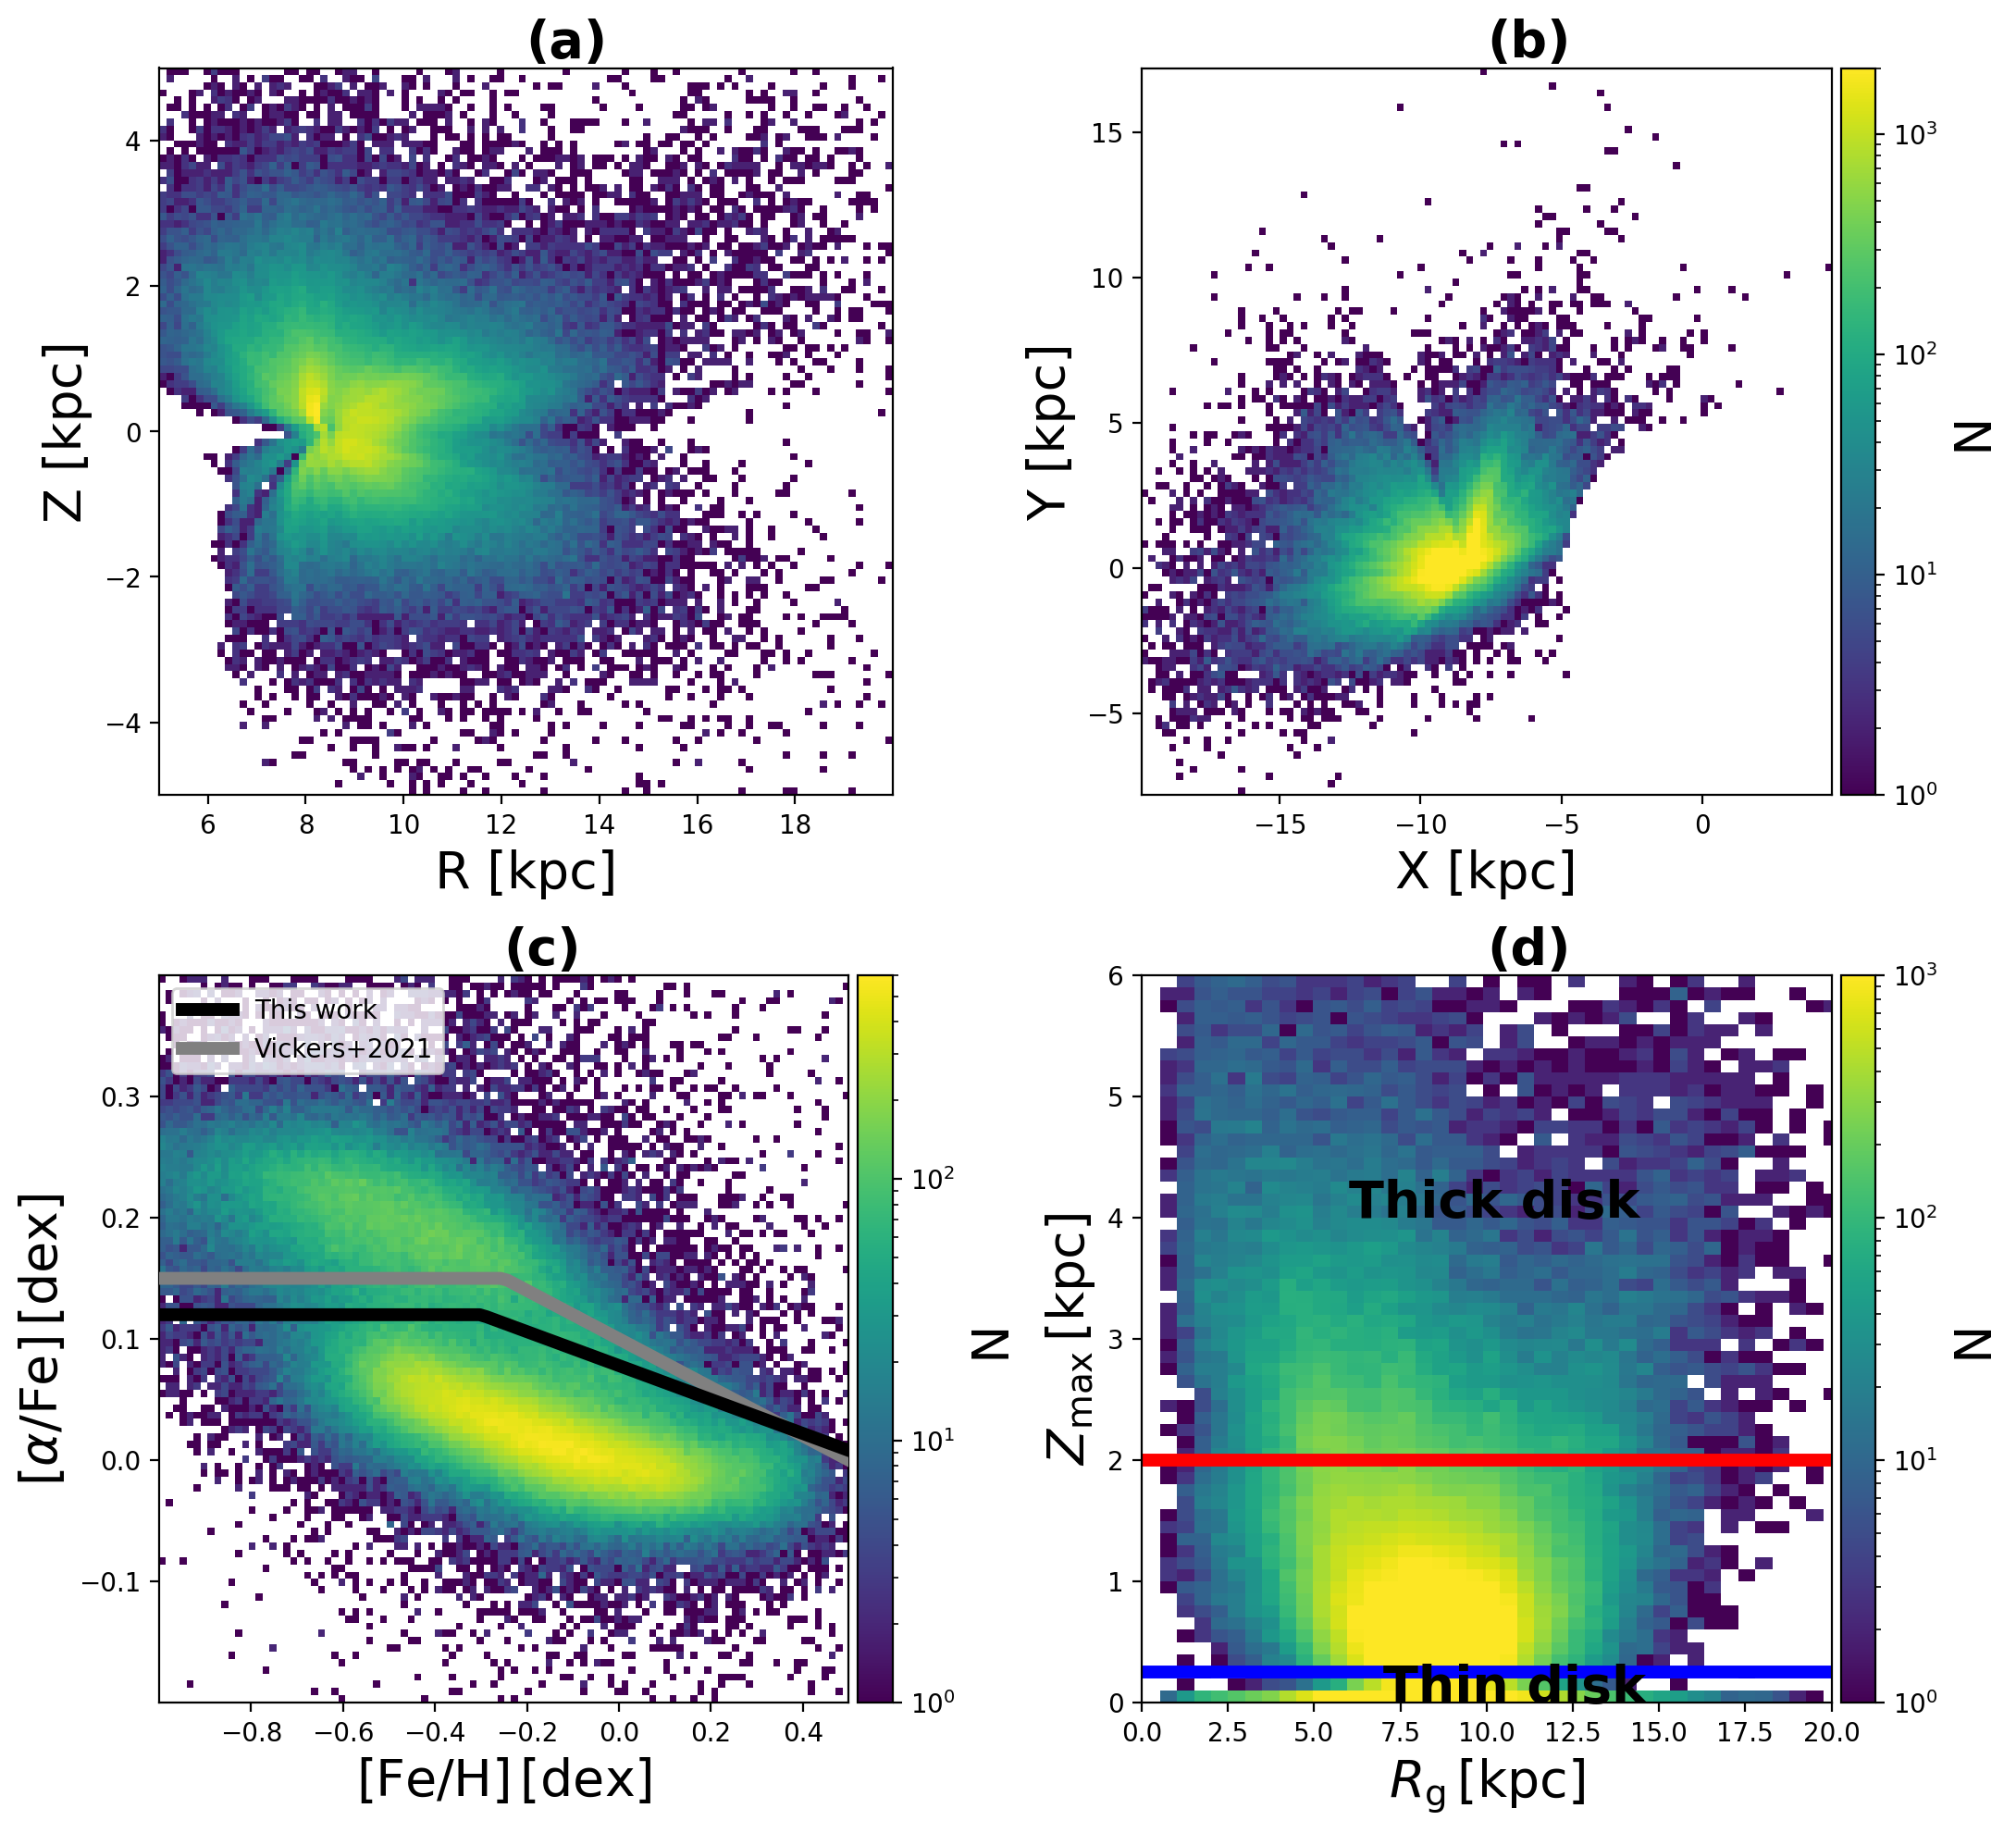

In [21]:
temp_fontdict = {"fontsize": 20}
fig,axes = plt.subplots(2,2,figsize=(11,10))
im0=hist2d(fig,axes[0,0],data[np.abs(data['z'])<5]['R'],data[np.abs(data['z'])<5]['z'],data[np.abs(data['z'])<5]['z'],stat='count',lognorm=True,vmin=1,vmax=2e3)
im1=hist2d(fig,axes[0,1],data['x'],data['y'],data['y'],stat='count',lognorm=True,vmin=1,vmax=2e3)
im2=hist2d(fig,axes[1,0],data['FEH_APOGEE'],data['AFE_APOGEE'],data['AFE_APOGEE'],stat='count',lognorm=True,vmin=1,vmax=6e2)
im3=hist2d(fig,axes[1,1],data[data['zmax']<10]['rg'],data[data['zmax']<10]['zmax'],data[data['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3);

divider = make_axes_locatable(axes[0,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im1,ax=axes[0,1],shrink=0.8,norm=mpl.colors.LogNorm(vmin=1,vmax=2e3),
                                cax=cax,orientation = 'vertical')
cbar.set_label("N",fontdict=temp_fontdict)

divider = make_axes_locatable(axes[1,0])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im2,ax=axes[1,0],shrink=0.8,norm=mpl.colors.LogNorm(vmin=1,vmax=4e2),
                                cax=cax,orientation = 'vertical')
cbar.set_label("N",fontdict=temp_fontdict)

divider = make_axes_locatable(axes[1,1])
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = fig.colorbar(im3,ax=axes[1,1],shrink=0.8,norm=mpl.colors.LogNorm(vmin=1,vmax=1e3),
                                cax=cax,orientation = 'vertical')
cbar.set_label("N",fontdict=temp_fontdict)
panels = ['(a)','(b)','(c)','(d)']
for i,ax in enumerate(axes.flatten()):
    ax.text(0.5,1.015,panels[i],transform=ax.transAxes,fontdict=font2)
    if i ==0:
        ax.set_xlabel("R [kpc]",fontdict=temp_fontdict)
        ax.set_ylabel("Z [kpc]",fontdict=temp_fontdict)
    if i ==1:
        ax.set_xlabel("X [kpc]",fontdict=temp_fontdict)
        ax.set_ylabel("Y [kpc]",fontdict=temp_fontdict)
    if i ==2:
        ax.set_xlabel(feh_label,fontdict=temp_fontdict)
        ax.set_ylabel(afe_label,fontdict=temp_fontdict)
        x = np.linspace(data['FEH_APOGEE'].min(),data['FEH_APOGEE'].max(),100)
        y = chem_select(x,a=-0.3,b=0.12,k=-0.14)
        y2=chem_select(x,a=-0.25,b=0.15,k=-0.1/0.5)
        ax.plot(x,y,lw=5,zorder=12,color='black',label='This work')
        ax.plot(x,y2,lw=5,zorder=10,color='grey',label='Vickers+2021')
        ax.legend(loc='upper left')
    if i ==3:
        ax.set_xlim([0,20])
        ax.set_ylim(0,6)
        ax.set_xlabel(rg_label,fontdict=temp_fontdict)
        ax.set_ylabel(zmax_label,fontdict=temp_fontdict)
        ax.text(6,4,"Thick disk",font2,color="black",zorder=10)
        ax.text(7,0,"Thin disk",font2,color='black',zorder=10)
        ax.hlines(xmin=0,xmax=20,y=0.25, color='blue', lw=5)
        ax.hlines(xmin=0,xmax=20, y=2, color='red', lw=5)
fig.tight_layout()
fig.savefig("figures/distributions.jpeg",dpi=300)

# Figure 3
Caption:

MGAR in the thin (upper) and thick (lower) disks, compared to V21 (black dots). Error bars are derived from the covariance matrix of the weighted OLS algorithm.

**Upper panel**: Thin disk gradients with fitted lines (blue: this work; gray: V21). The shaded region marks the 98% highest density interval (HDI) for the corresponding fitted line. Check the caption of Figure 10 in the Appendix for prior specifications.

**Lower panel**: Thick disk gradients.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 9 seconds.
There were 132 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 10 seconds.
There were 7 divergences after tuning. Increase `target_accept` or reparameterize.


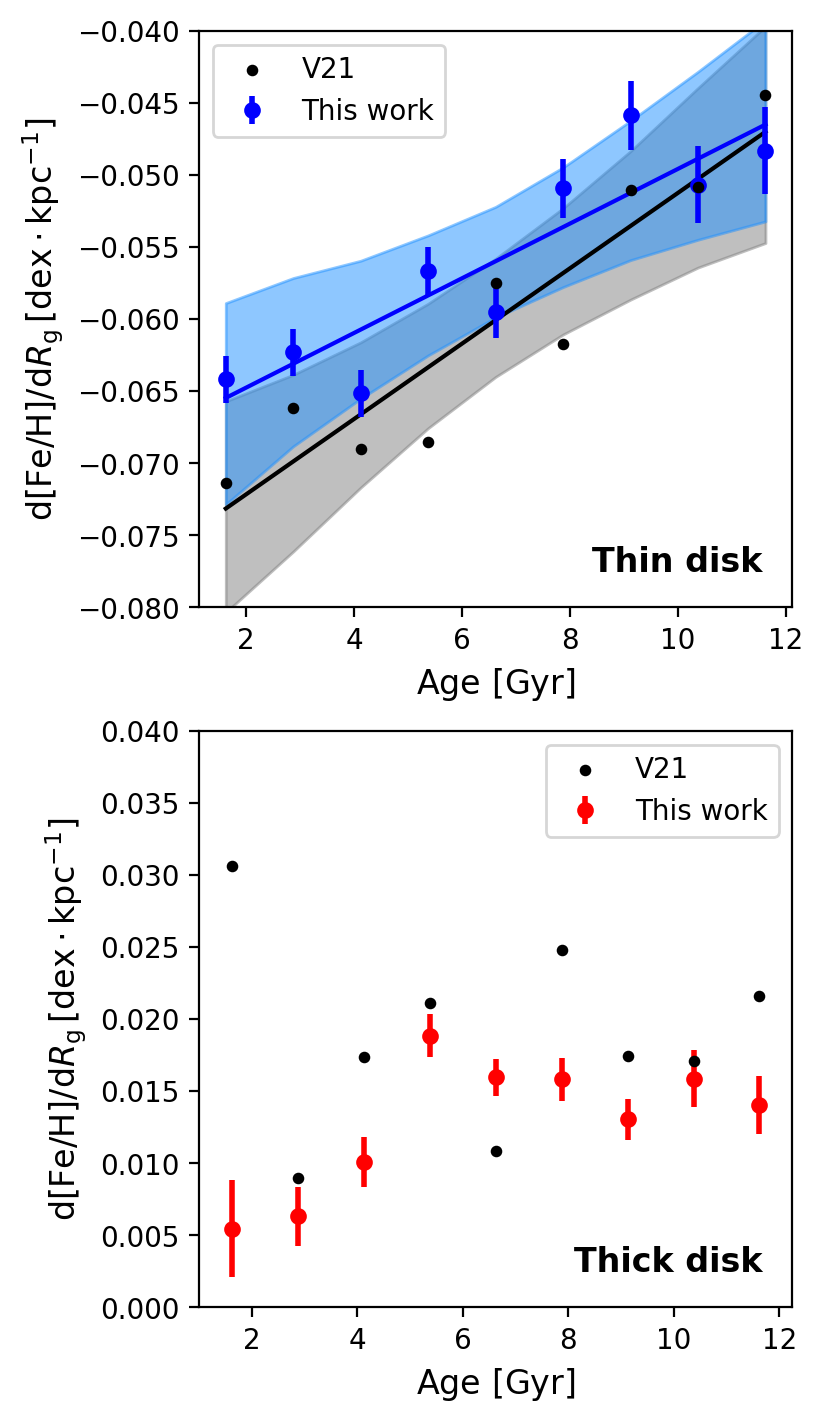

In [22]:
fig,axes,thin,thick,thin_grad,thin_b,thin_err,thick_grad,thick_b,thick_err, trace_thin, trace_john = plot_MGARs(data, data_name='This work')
fig.savefig('figures/main_result.pdf')

# Figure 2

Caption:

**Upper panel**: Thin (blue) and thick (red) disk stars on the [Fe/H]–Rg plane. The metallicity of thin disk stars is centered around zero and decreases with Rg, while thick disk stars are more metal-poor on average ([Fe/H]∼ −0.6 dex) but show a positive metallicity gradient with Rg.

**Lower panel**: Age distributions. The thin disk population is statistically younger and more numerous than the thick disk.


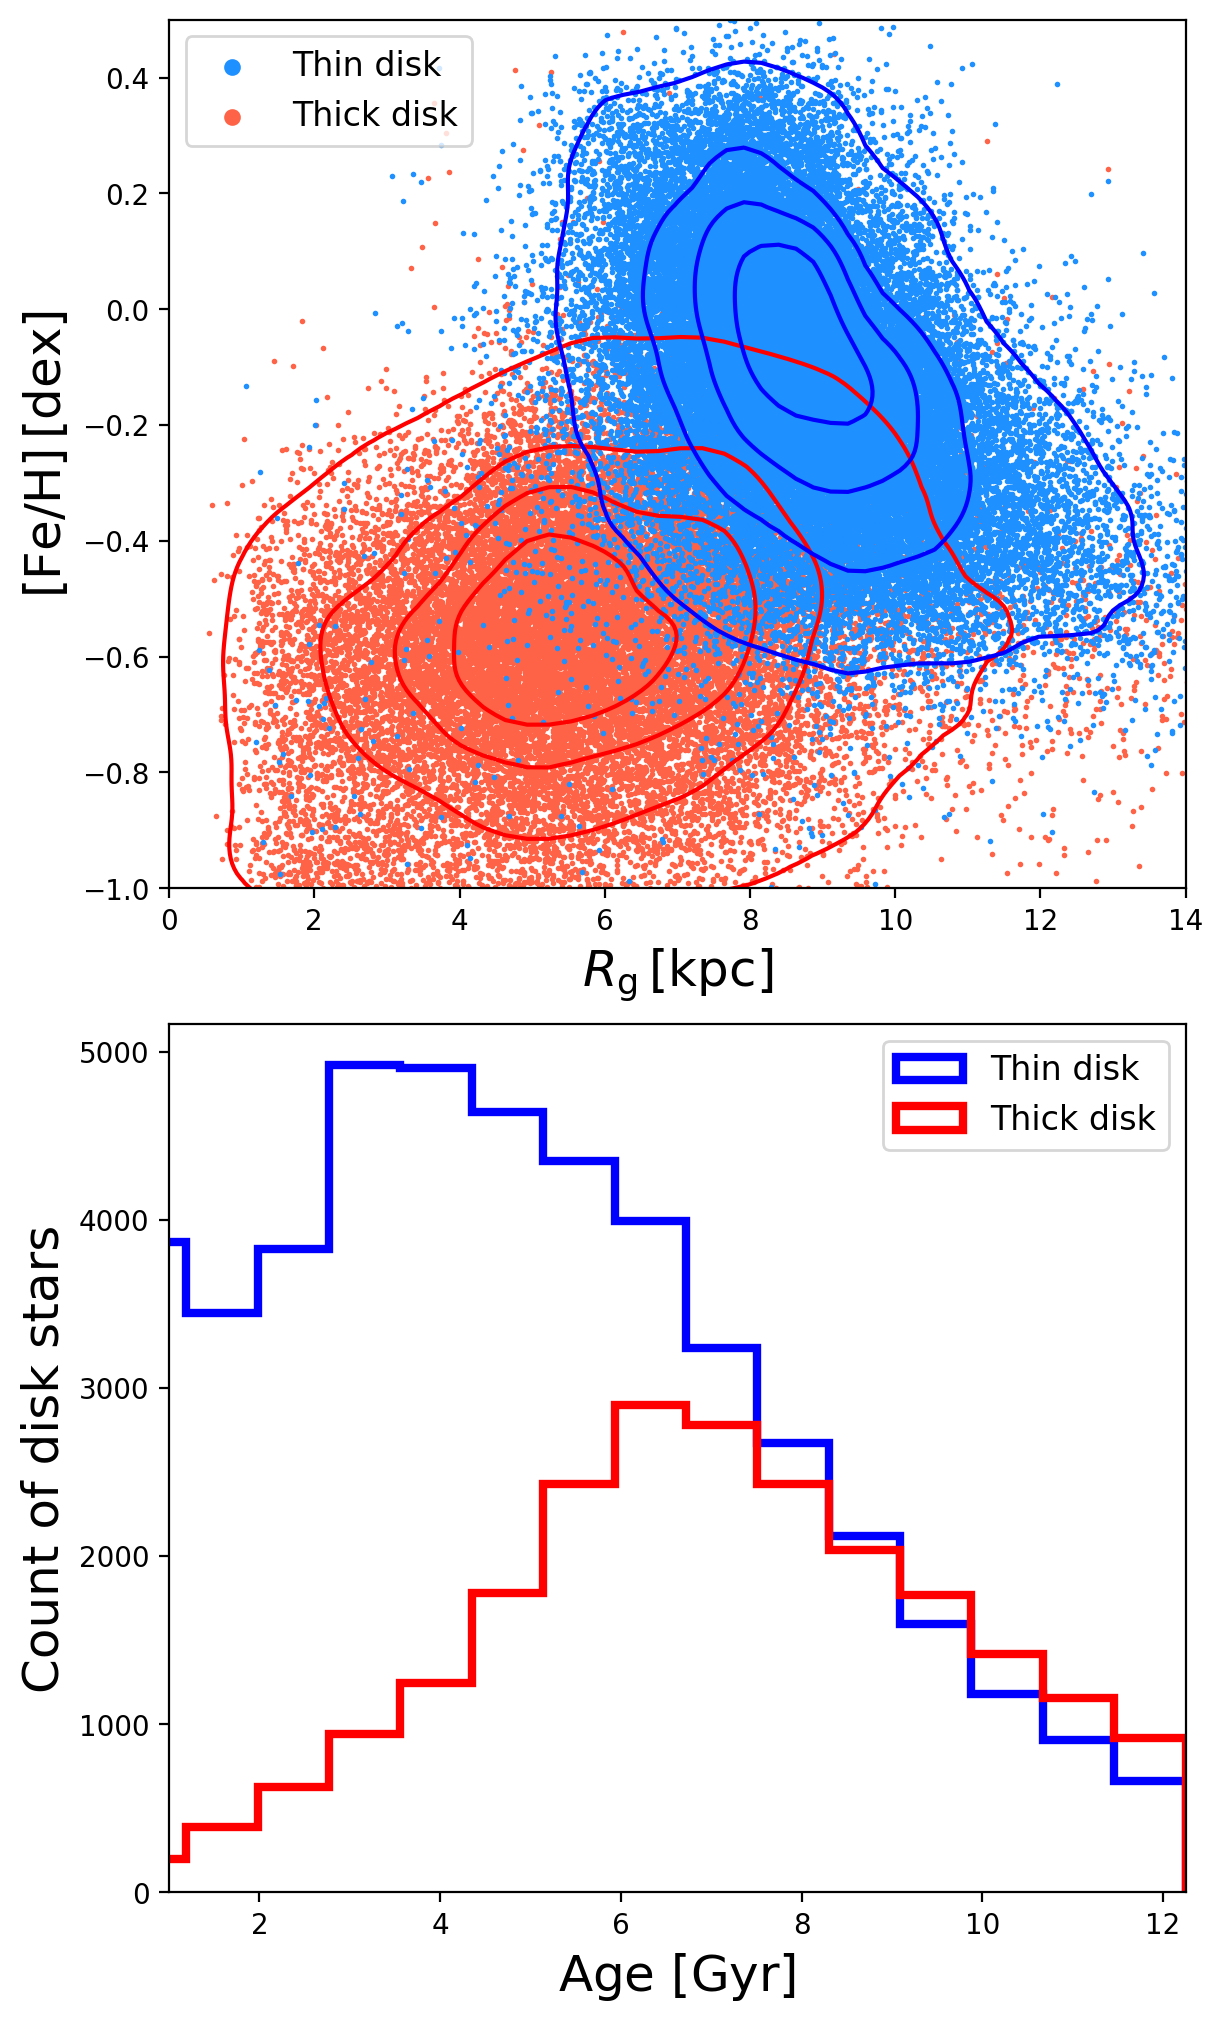

In [23]:
temp_fontdict = {"fontsize": 18}
fig,axes=plt.subplots(2,1,figsize=(6,10),constrained_layout=True)
ax=axes[0]
ax.set_ylabel(feh_label, fontdict=temp_fontdict)
ax.set_xlabel(rg_label, fontdict=temp_fontdict)
ax.scatter(x=thin['rg'],y=thin['FEH_APOGEE'],color='dodgerblue',label='Thin disk',s=1,zorder=1)
ax.scatter(x=thick['rg'],y=thick['FEH_APOGEE'],color="tomato",label='Thick disk',s=1,zorder=0)
sns.kdeplot(x=thin['rg'],y=thin['FEH_APOGEE'],color='blue',levels=5,ax=ax,zorder=3)
sns.kdeplot(x=thick['rg'],y=thick['FEH_APOGEE'],color='red',levels=5,ax=ax,zorder=2)
ax.set_ylim(-1,0.5)
ax.set_xlim(0,14)
ax.legend(loc='upper left', fontsize=12, markerscale=5)

thin_=thin[thin['age']<agebin[-1]]
thick_=thick[thick['age']<agebin[-1]]
agebins=np.linspace(min(thin_['age'].min(),thick_['age'].min()), max(thin_['age'].max(),thick_['age'].max()),40)
axes[1].hist(thin_['age'],histtype='step',density=False,bins=agebins,lw=3,label='Thin disk',color='blue')
axes[1].hist(thick_['age'],histtype='step',density=False,bins=agebins,lw=3,label='Thick disk',color='red')
axes[1].axis([agebin[0],agebin[-1],0,None])
axes[1].set_ylabel("Count of disk stars", fontdict=temp_fontdict)
axes[1].set_xlabel(age_label,fontdict=temp_fontdict)
axes[1].legend(loc='upper right', fontsize=12)
fig.savefig("figures/thin_thick.jpeg",dpi=300)

# Figure 4

Caption:

Gradient fitting for thin disk (upper three rows) and thick disk (lower three rows) mono-age populations. Each panel in the right three columns specifies the corresponding age bin and star count within the bin, contours include 20%, 80%, and 95% of the corresponding populations. The left column lists the MGARs, [Fe/H]–[α/Fe] and Zmax–Rg space of the thin and thick disks. We take three populations in the thin disk (denoted by young, intermediate and old) in Figure 5 to show how the gradient value flattening with age.

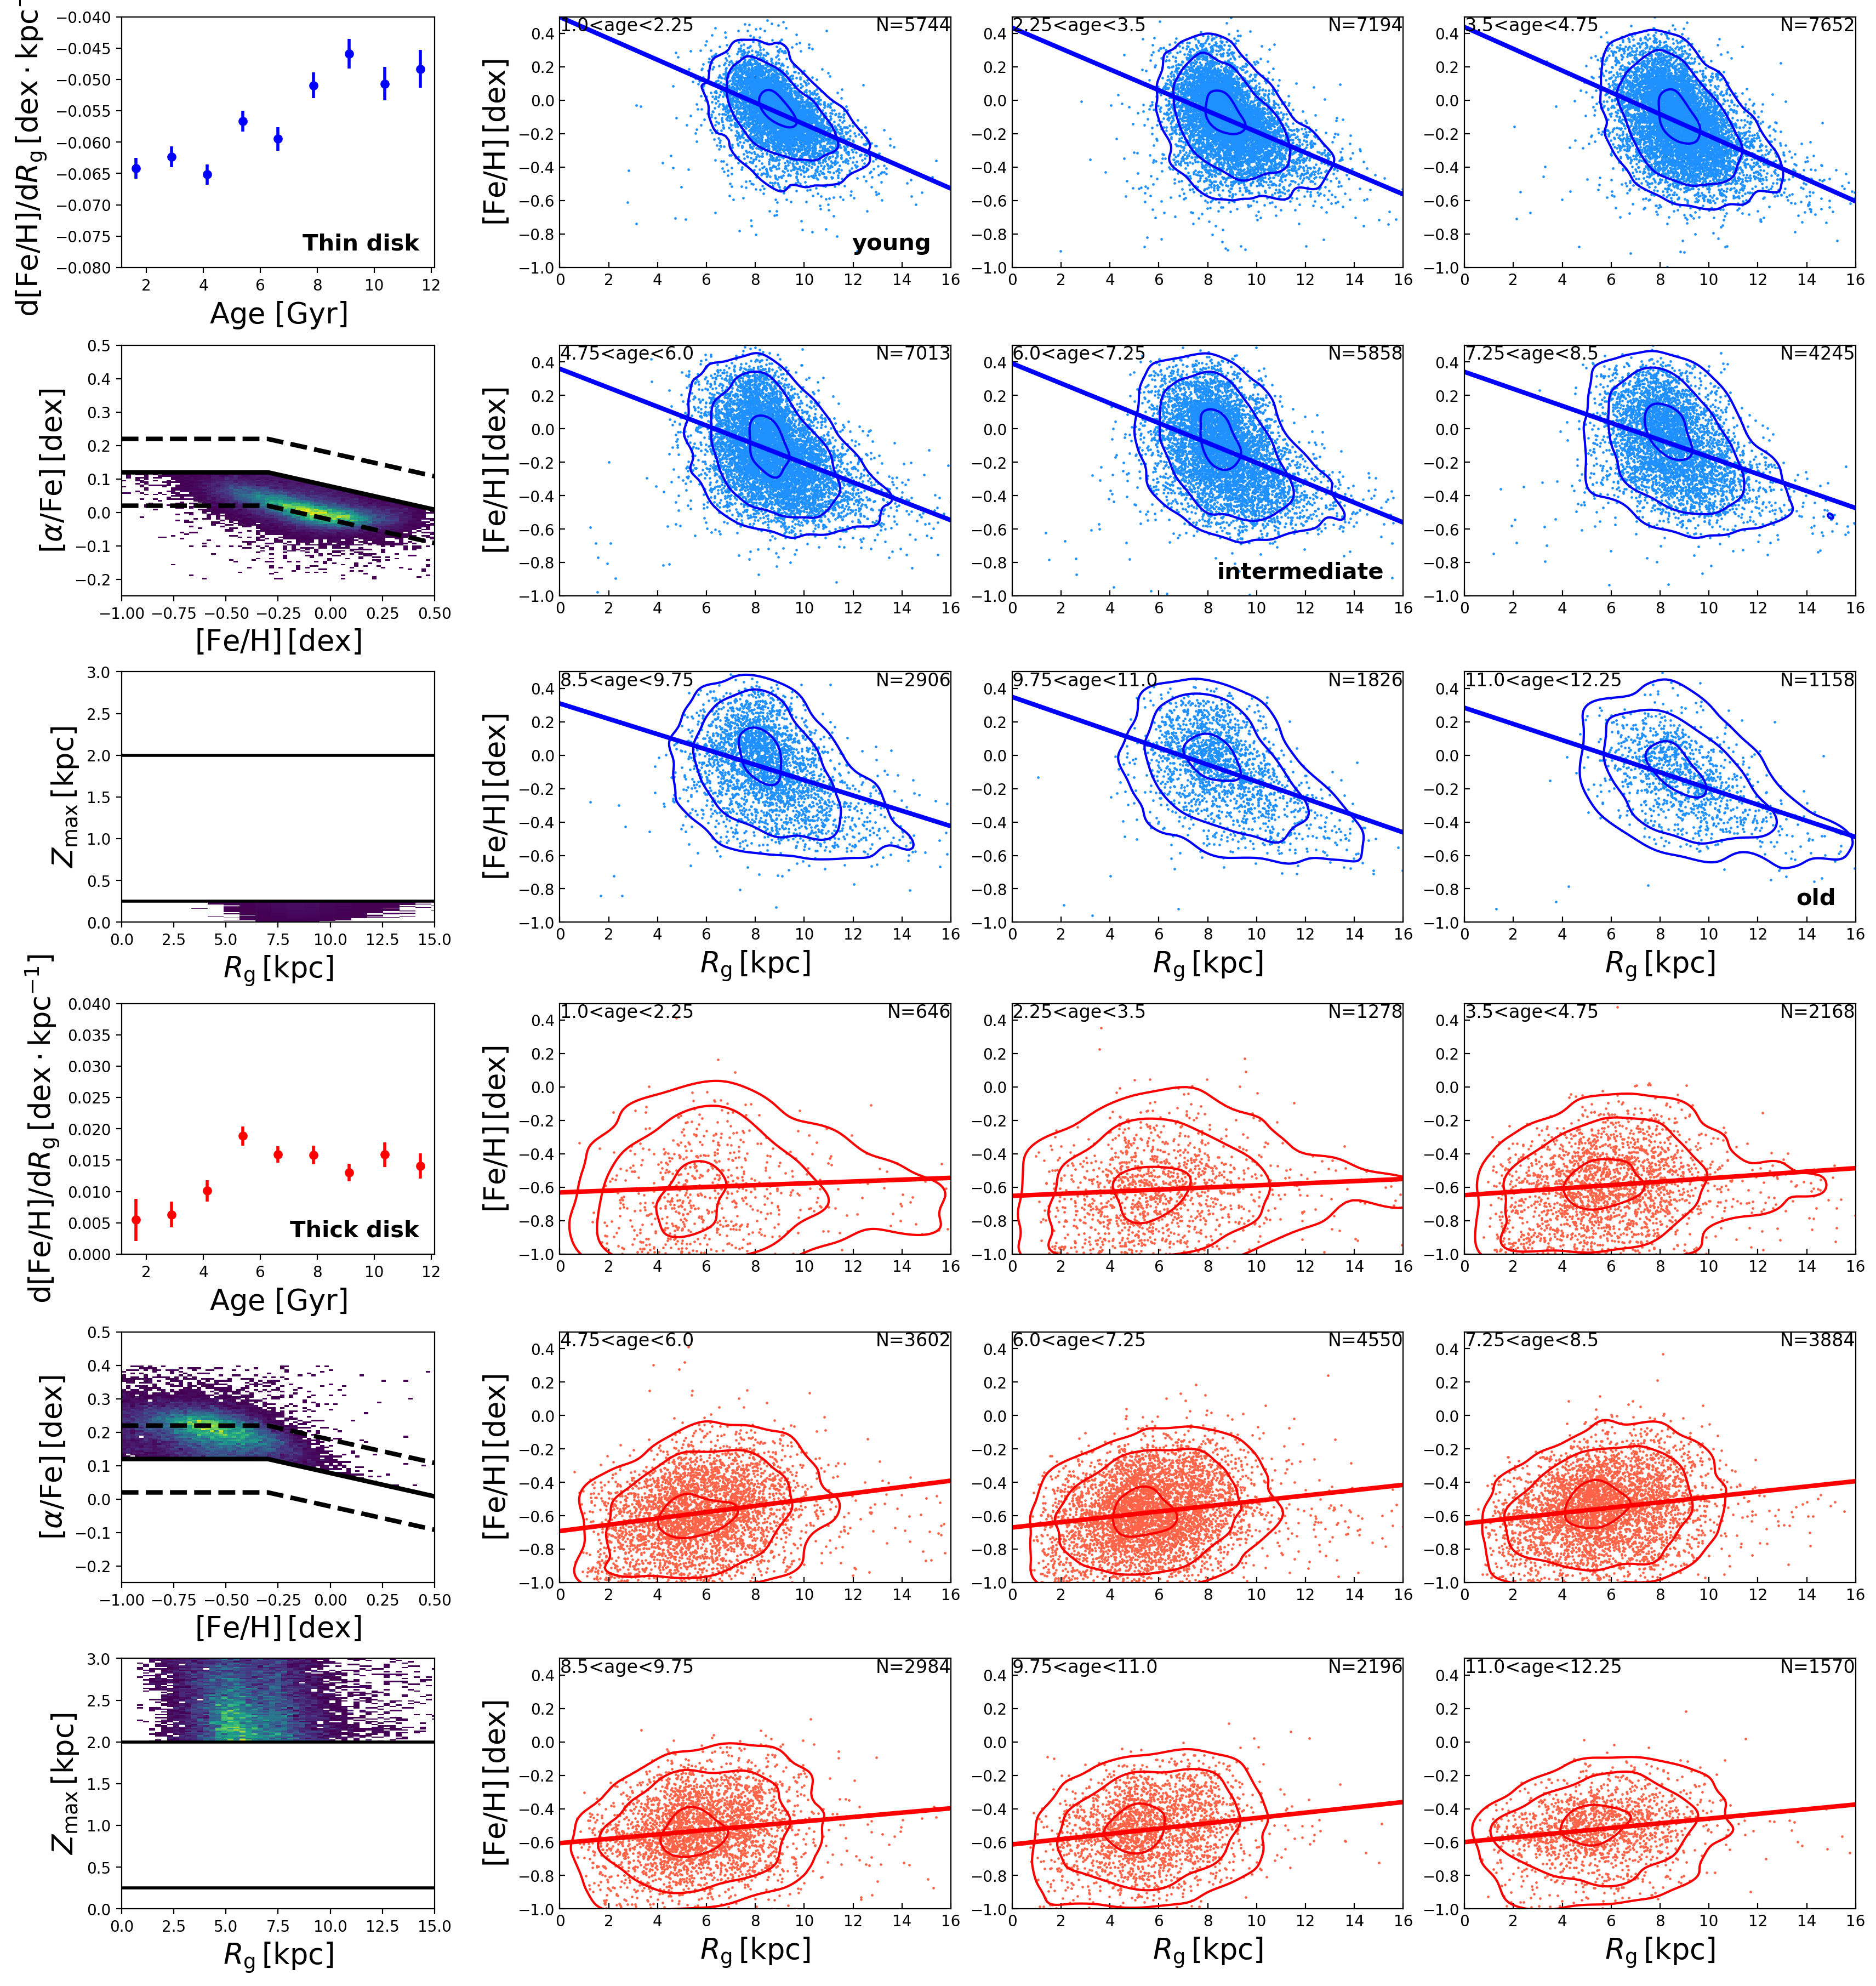

In [24]:
def scatter_feh_rg(ax,data,contour_color, **kwarg):
    ax.scatter(data['rg'].values, data['FEH_APOGEE'].values,s=.5,**kwarg)
    kde=sns.kdeplot(x=data['rg'].values, y=data['FEH_APOGEE'].values,color=contour_color,levels=[0.05, 0.2, 0.8], thresh=0.1,ax=ax)
x_ = np.linspace(-1,0.5,500)
z_cuts = [0, 0.25, 2, np.inf]
rg1 = np.linspace(0,20,100)
rg2 = np.linspace(0,20,100)
lognorm=mpl.colors.LogNorm(vmin=1,vmax=1e4)
temp_fontdict = {'size': 19}
fig,axes=plt.subplots(6,4,figsize=(17,18),constrained_layout=True)
for i,ax in enumerate(axes.flatten()):
    if i == 0:
        #ax.scatter(age_binedge, john_result0,s=15,color='black',zorder=10,label='V21')
        #ax.errorbar(age_anders,anders[:,0],yerr=[anders[:,1], anders[:,2]],fmt='.r',lw=1,ms=10,label='Anders+2023')
        #ax.scatter(*bridget.T,s=15,color='green',zorder=5,label='Ratcliffe+2023')
        #ax.set_xlabel("age/Gyr",fontdict=label_font)
        #ax.set_ylabel("$\mathbf{\mathbf{d}[Fe/H]/\mathbf{d}R_g}$",fontdict=label_font)
        ax.set_ylim(-0.08,-0.04)
        ax.set_xlabel(age_label,fontdict=temp_fontdict)
        ax.set_ylabel(grad_label,fontdict=temp_fontdict)
        ax.errorbar(age_binedge,thin_grad,yerr=thin_err,fmt='.',color="blue",lw=2,ms=10)

        #ax.legend()
    elif i == 4:
        ax.hist2d(thin['FEH_APOGEE'],thin["AFE_APOGEE"],cmin=1,bins=(70,70),cmap='viridis');
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14),color='black',linestyle='-',lw=3)
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14)+0.1,color='black',linestyle='--',lw=3)
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14)-0.1,color='black',linestyle='--',lw=3)
        ax.axis([-1,0.5,-0.25,0.5])
        ax.set_xlabel(feh_label, fontdict=temp_fontdict)
        ax.set_ylabel(afe_label, fontdict=temp_fontdict)
    elif i == 8:
        ax.hist2d(thin[thin['zmax']<3]['rg'],thin[thin['zmax']<3]['zmax'],cmin=1,bins=(60,60),cmap='viridis');
        for j in range(2):
            ax.hlines(z_cuts[j+1], 0, 15, color='black', lw=2)
        ax.axis([0,15,0,3])
        ax.set_xlabel(rg_label, fontdict=temp_fontdict)
        ax.set_ylabel(zmax_label, fontdict=temp_fontdict)
    elif i==12:
        #ax.scatter(age_binedge, john_result1,s=15,color='black',zorder=10,label='Original V21')
        ax.set_xlabel(age_label,fontdict=temp_fontdict)
        ax.set_ylabel(grad_label,fontdict=temp_fontdict)
        ax.set_ylim(0,.04)
        ax.set_xlabel(age_label,fontdict=temp_fontdict)
        ax.set_ylabel(grad_label,fontdict=temp_fontdict)
        ax.errorbar(age_binedge,thick_grad,yerr=thick_err,fmt='.',color="red",lw=2,ms=10)

        #ax.legend()
    elif i == 16:
        ax.hist2d(thick['FEH_APOGEE'],thick["AFE_APOGEE"],cmin=1,bins=(70,70),cmap='viridis');
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14),color='black',linestyle='-',lw=3)
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14)+0.1,color='black',linestyle='--',lw=3)
        ax.plot(x_,chem_select(x_,a=-0.3,b=.12,k=-.14)-0.1,color='black',linestyle='--',lw=3)
        ax.axis([-1,0.5,-0.25,0.5])
        ax.set_xlabel(feh_label, fontdict=temp_fontdict)
        ax.set_ylabel(afe_label, fontdict=temp_fontdict)
    elif i == 20:
        ax.hist2d(thick[thick['zmax']<3]['rg'],thick[thick['zmax']<3]['zmax'],cmin=1,bins=(60,60),cmap='viridis');
        for j in range(2):
            ax.hlines(z_cuts[j+1], 0, 15, color='black', lw=2)
        ax.axis([0,15,0,3])
        ax.set_xlabel(rg_label, fontdict=temp_fontdict)
        ax.set_ylabel(zmax_label, fontdict=temp_fontdict)
    elif 0<i<12:
        data_=thin
        data_age_bined = data_[(data_['age']>agebin[i-1*(i//4)-1])&(data_['age']<agebin[i-1*(i//4)])]
        scatter_feh_rg(ax,data_age_bined,contour_color='blue', **{"color":"dodgerblue"})
        #ax.errorbar(x=data_age_bined['rg'].values,y=data_age_bined['FEH_APOGEE'].values,xerr=data_age_bined['erg'].values,
        #                    yerr=data_age_bined['err_feh_apogee'].values,
        #                   alpha=.2,fmt='none',elinewidth=1,zorder=-10,ecolor='grey')
        ax.plot(rg1, thin_grad[i-1*(i//4)-1]*rg1+thin_b[i-1*(i//4)-1],lw=3,c='blue')
        ax.set_ylim(-1,.5)
        ax.set_xlim(0, 16)
        ax.text(1, 1, f'N={len(data_age_bined)}',transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
        ax.text(0, 1, f"{agebin[i-1*(i//4)-1]}<age<{agebin[i-1*(i//4)]}", transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        #ax.set_title(f"{agebin[i-1*(i//4)-1]}<age<{agebin[i-1*(i//4)]}",fontdict=title_font)
    elif 12<i<24:
        data_=thick
        data_age_bined = data_[(data_['age']>agebin[i-1*((i-12)//4)-13])&(data_['age']<agebin[i-12-1*((i-12)//4)])]
        scatter_feh_rg(ax,data_age_bined,contour_color='red', **{"color":"tomato"})
        #ax.errorbar(x=data_age_bined['rg'].values,y=data_age_bined['FEH_APOGEE'].values,xerr=data_age_bined['erg'].values,
        #                    yerr=data_age_bined['err_feh_apogee'].values,
        #                   alpha=.2,fmt='none',elinewidth=1,zorder=-10,ecolor='grey')
        ax.plot(rg2, thick_grad[i-1*((i-12)//4)-13]*rg2+thick_b[i-1*((i-12)//4)-13],lw=3,c='red')
        ax.set_ylim(-1,.5)
        ax.set_xlim(0,16)
        ax.text(1, 1, f'N={len(data_age_bined)}',transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='right')
        ax.text(0, 1, f"{agebin[i-1*((i-12)//4)-13]}<age<{agebin[i-1*((i-12)//4)-12]}", transform=ax.transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left')
        #ax.set_title(f"{agebin[i-1*((i-12)//4)-13]}<age<{agebin[i-1*((i-12)//4)-12]}",fontdict=title_font)
        #if 12<i<16:
        #    rect = patches.Rectangle((9.5, -1), 3, 0.8, linewidth=2, edgecolor='red',lw=3, facecolor='none')
            # 将长方形添加到图中
        #    ax.add_patch(rect)
    if i%4==0:
        ax.set_box_aspect(0.8)
    else:    
        ax.tick_params(top=False,bottom=True, left=True, right=False,direction="in",which="both")
    if 8<i<12:
        ax.set_xlabel(rg_label, fontdict=temp_fontdict)
    if i>20:
        ax.set_xlabel(rg_label, fontdict=temp_fontdict)
    if (i-1)%4==0:
        ax.set_ylabel(feh_label, fontdict=temp_fontdict)
    if i in [1, 6, 11]:
        ax.text(0.95, 0.05, f"{three_age_labels[i//5]}", transform=ax.transAxes, fontsize=15, verticalalignment='bottom', horizontalalignment='right', weight='bold')
axes[0, 0].text(0.95, 0.05, 'Thin disk', horizontalalignment='right',verticalalignment='bottom', transform=axes[0, 0].transAxes,fontsize=15, weight='bold')
axes[3, 0].text(0.95, 0.05, 'Thick disk', horizontalalignment='right',verticalalignment='bottom', transform=axes[3, 0].transAxes,fontsize=15, weight='bold')
fig.savefig(f'figures/detail.jpeg',dpi=300)

# Figure 5

Caption:

Demonstration of gradient flattening with age in the thin disk, using young (1–2.25 Gyr), intermediate (6–7.25 Gyr), and old (11–12.25 Gyr) populations from Figure 4. The first three panels show their [Fe/H]–Rg distributions with 20%, 80%, and 95% contours. While the standard deviation of [Fe/H] remains similar across all three mono-age populations, the standard deviation of Rg increases with age, indicating that the expanding Rg range plays a major role in flattening the gradient. The shaded regions in the last panel represent the moving 10% highest density interval (HDI) of [Fe/H], highlighting the trend more clearly.

rg std of young: 1.273
feh std of young: 0.171
rg std of intermediate: 1.607
feh std of intermediate: 0.232
rg std of old: 1.984
feh std of old: 0.216


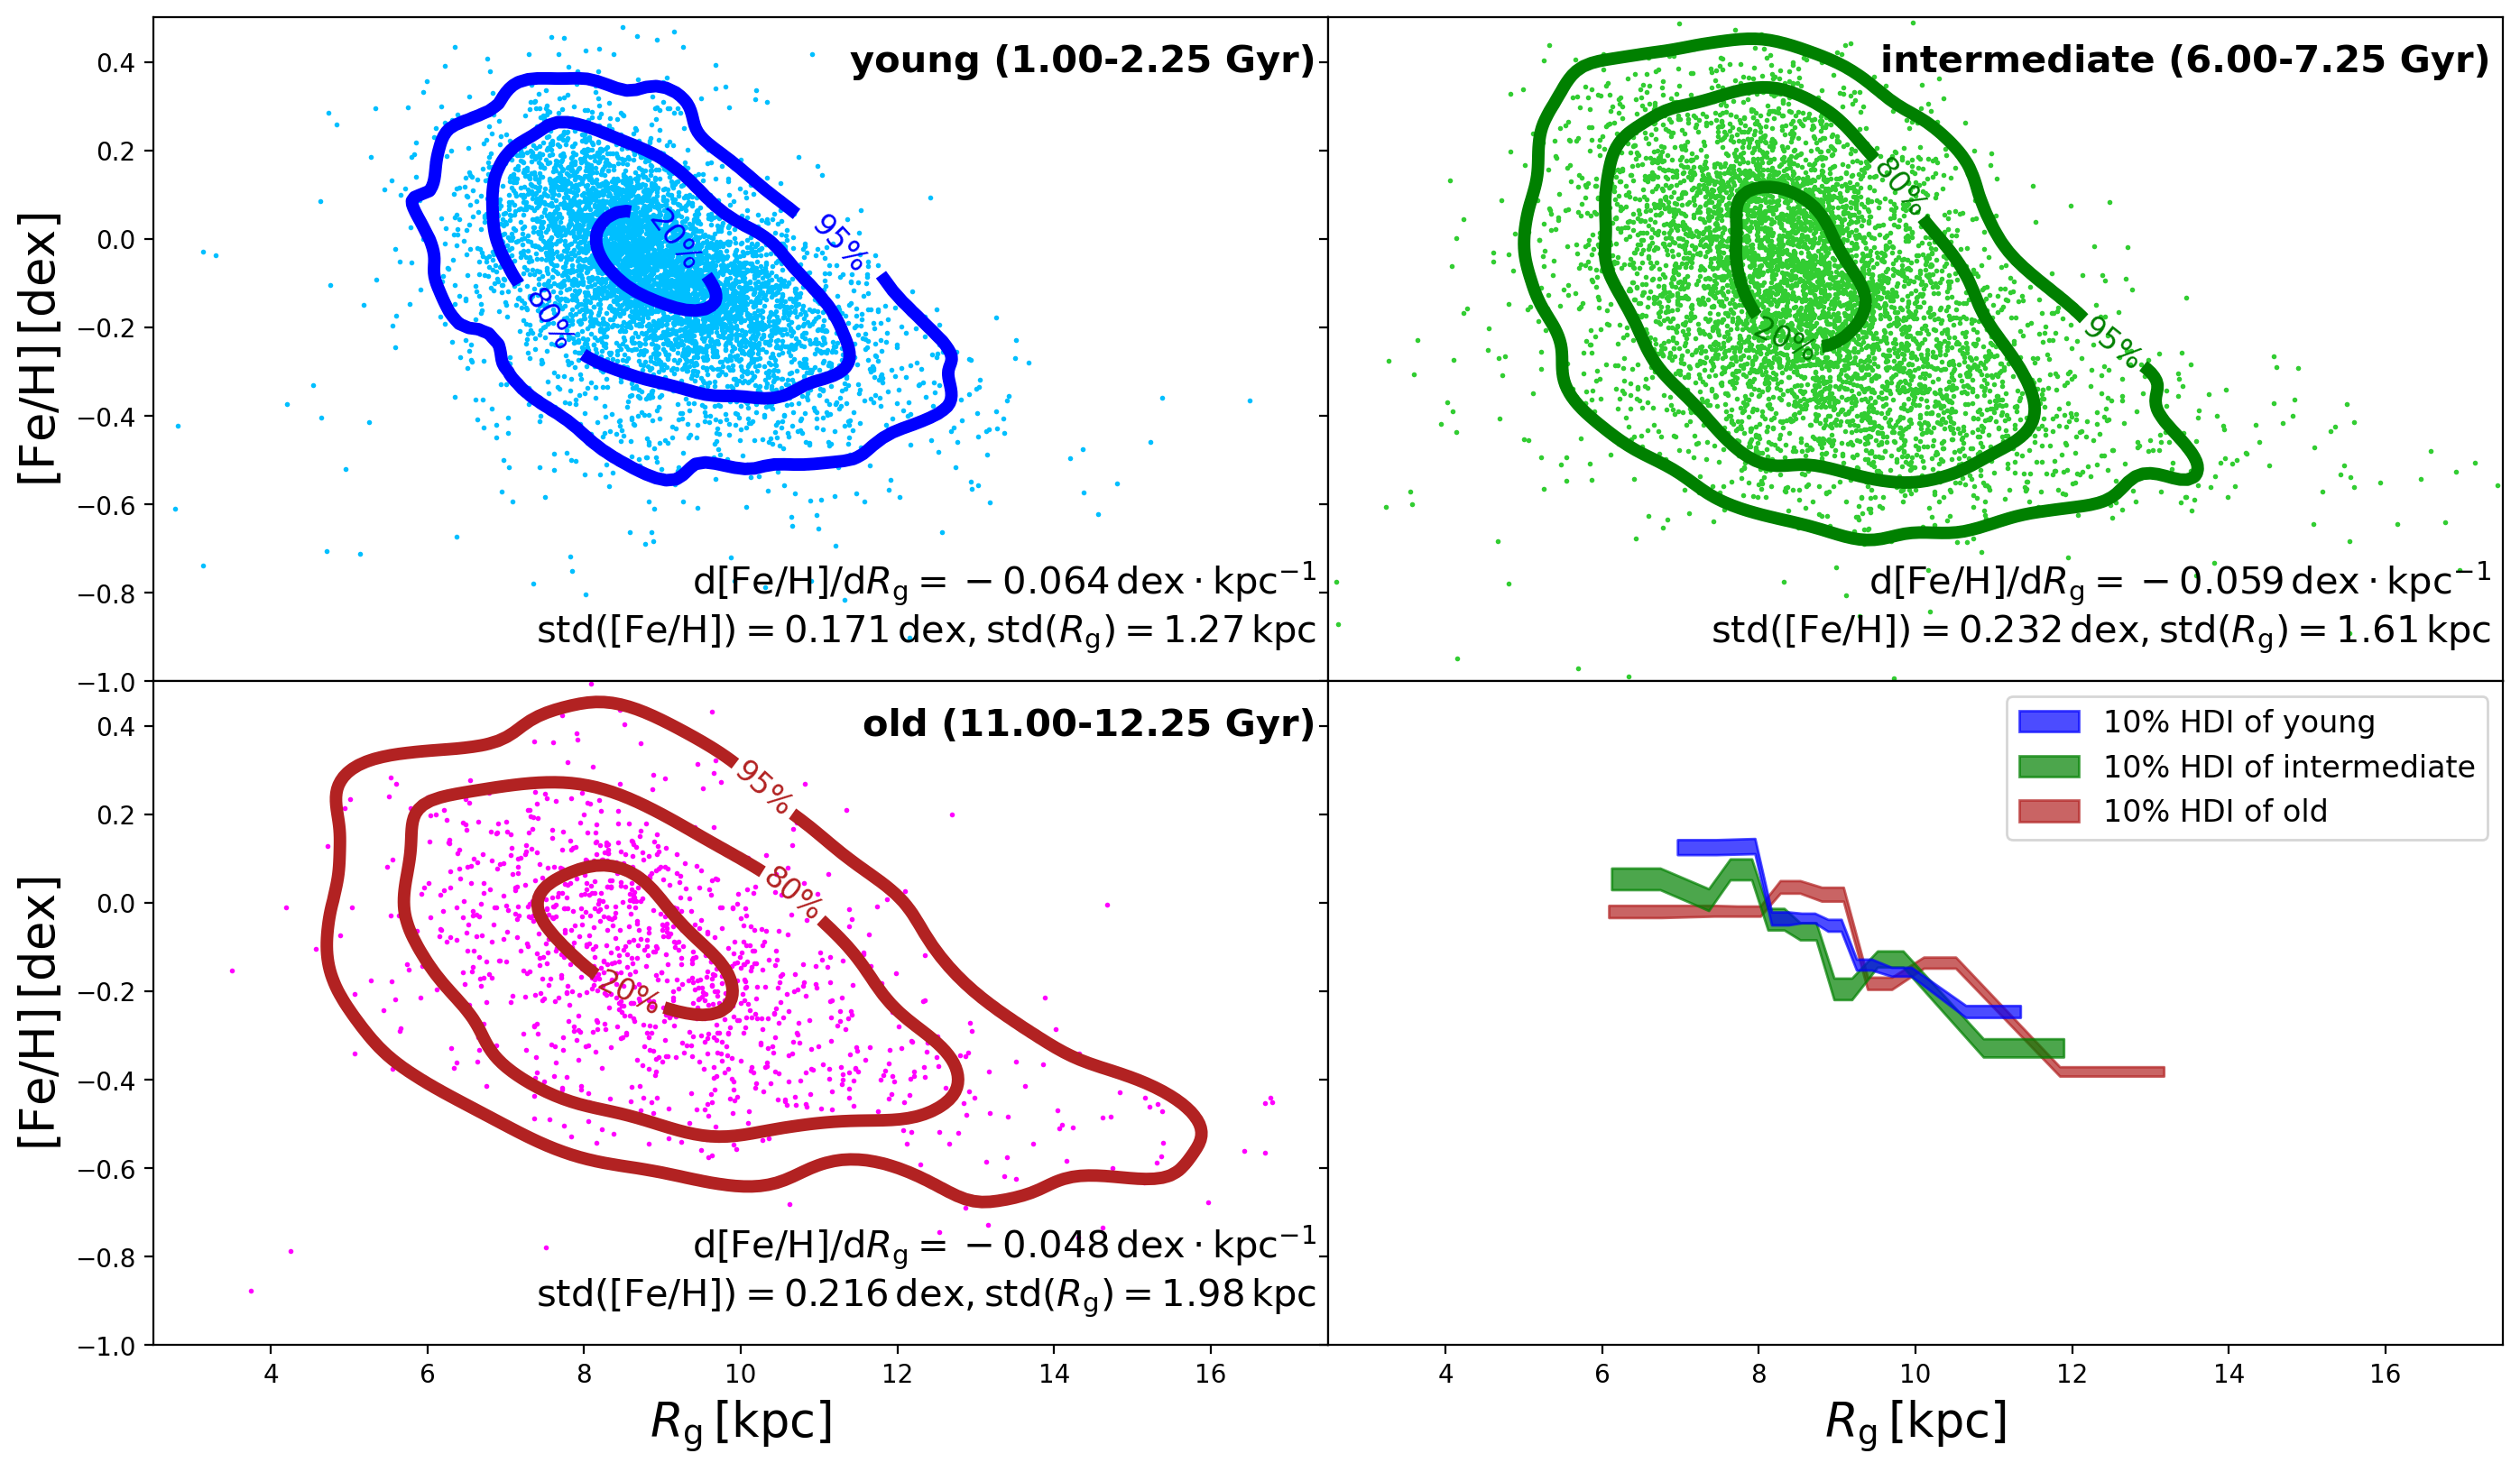

In [25]:
fig,axes=plt.subplots(2, 2, figsize=(14, 8), sharex=True, sharey=True)
fig.subplots_adjust(top=0.99, bottom=0.07, left=0.06, right=0.99, hspace=0, wspace=0)
axes = axes.flatten()
thin_ = thin[(thin['age']<agebin[-1])&(thin['age']>agebin[0])]
colors = ['deepskyblue', 'limegreen', "magenta"]
color2 = ['blue', 'green', 'firebrick']

new_agebin = agebin
new_slopes = []
new_b = []
x_ = np.linspace(2.5, 17.5,100)
rg_range = np.zeros((3, 2))
feh_range = np.zeros((3, 2))
for i in range(3):
    pop = thin_[(thin_['age'] > new_agebin[i*4]) & (thin_['age'] < new_agebin[i*4+1])]
    x = pop['rg'].values
    y = pop['FEH_APOGEE'].values
    print(f"rg std of {three_age_labels[i]}: " + f'{np.std(x):.3f}')
    print(f"feh std of {three_age_labels[i]}: " + f'{np.std(y):.3f}')
    xe = pop['erg'].values
    ye = pop['err_feh_apogee'].values
    model = Model(linear_func)
    data_ = RealData(x, y, sx=xe, sy=ye)
    odr = ODR(data_, model, beta0=[0., 10.])
    odr.set_job(fit_type=2)
    out = odr.run()
    slope = out.beta[0]
    b = out.beta[1]
    new_slopes.append(slope)
    new_b.append(b)
    rg = pop['rg'].values
    feh = pop['FEH_APOGEE'].values
  
    axes[i].scatter(x=pop['rg'].values, y=pop['FEH_APOGEE'].values, s=1, color=f"{colors[i]}")
    ct = sns.kdeplot(x=pop['rg'].values, y=pop['FEH_APOGEE'].values, levels=[0.05, 0.2, 0.8], ax=axes[i], zorder=3, linewidths=5, color=f"{color2[i]}") 
    cset_list = [child for child in ct.get_children() if isinstance(child, mpl.contour.QuadContourSet)]
    if cset_list:
        cset = cset_list[0]

        level_mapping = {level: f"{int(100-cum*100)}%" for level, cum in zip(cset.levels, [0.05, 0.2, 0.8])}
    
        ct.clabel(cset, inline=True, fontsize='large', fmt=level_mapping)
    axes[i].text(0.99, 0.96, f"{three_age_labels[i]} ({new_agebin[i*4]:.2f}-{new_agebin[i*4+1]:.2f} Gyr)", transform=axes[i].transAxes, fontsize=15, verticalalignment='top', horizontalalignment='right', weight='bold', zorder=10)
    axes[i].text(0.99, 1-0.96, f"$\\mathrm{{d[Fe/H]}}/\\mathrm{{d}}R_\\mathrm{{g}}={slope:.3f}\\,\\mathrm{{dex \\cdot kpc^{{-1}}}}$\n$\\mathrm{{std([Fe/H])}} = {np.std(pop['FEH_APOGEE'].values):.3f}\\,\\mathrm{{dex}}\\mathrm{{, std}}(R_\\mathrm{{g}}) = {np.std(pop['rg'].values):.2f}\\,\\mathrm{{kpc}}$", transform=axes[i].transAxes, fontsize=15, verticalalignment='bottom', horizontalalignment='right', weight='bold', zorder=10)
    axes[i].set_ylim(-1, 0.5)
    axes[i].set_xlim(2.5, 17.5)

    N = 9
    hdi_10 = np.zeros((2, 2*N-3))

    rgbins_major = np.linspace(np.percentile(pop['rg'].values,1), np.percentile(pop['rg'].values, 99), N)
    rgbins_major = np.percentile(pop['rg'].values, np.linspace(1, 99, N))
    rgbins_minor = (rgbins_major[:-1]+rgbins_major[1:])/2
    rg_major_center = rgbins_minor
    rg_minor_center = (rgbins_minor[:-1]+rgbins_minor[1:])/2
    combined_center = np.zeros(2*N-3)
    combined_center[::2] = rg_major_center
    combined_center[1::2] = rg_minor_center
    for j in range(2*N-3):
        if j//2 == 0:
            major_mask = (pop['rg'].values >= rgbins_major[j//2]) & (pop['rg'].values <= rgbins_major[j//2+1])
            w2 = pop[major_mask]
            hdi_10[:, j] = az.hdi(w2['FEH_APOGEE'].values, hdi_prob=0.1)
        else:
            minor_mask = (pop['rg'].values >= rgbins_minor[(j-1)//2]) & (pop['rg'].values <= rgbins_minor[(j-1)//2+1])
            w2 = pop[minor_mask]
            hdi_10[:, j] = az.hdi(w2['FEH_APOGEE'].values, hdi_prob=0.1)

    axes[-1].fill_between(combined_center, hdi_10[0, :], hdi_10[1, :], color=color2[i], label=f'10% HDI of {three_age_labels[i]}', zorder=-2*i, alpha=0.7)

axes[-1].legend(loc='upper right', fontsize=12, markerscale=5)
axes[3].set_xlim(2.5, 17.5)
axes[3].set_ylim(-1,.5)
axes[0].set_ylabel(feh_label,fontdict=temp_fontdict)
axes[2].set_ylabel(feh_label,fontdict=temp_fontdict)
axes[2].set_xlabel(rg_label,fontdict=temp_fontdict)
axes[-1].set_xlabel(rg_label,fontdict=temp_fontdict);
fig.savefig('figures/three_pops.pdf')

# Figure 6

Caption:

Comparison of the MGAR in the thin disk from this work (blue dots), V21 (black dots) with stellar birth gradient evolution from Ratcliffe et al. (2023) (red dots, the steepening from 12 to 10 Gyr was attributed to GES) and Lu et al. (2024) (cyan dots), similar to Figure 11 of Anders et al. (2023), to illustrate the potential influence of churning: old stars have more time to experience churning which results in flatter observed gradient than corresponding birth gradient. For stars just formed today, there is no time for churning and the observed gradient converges with birth gradient at~ −0.07 dex/kpc.

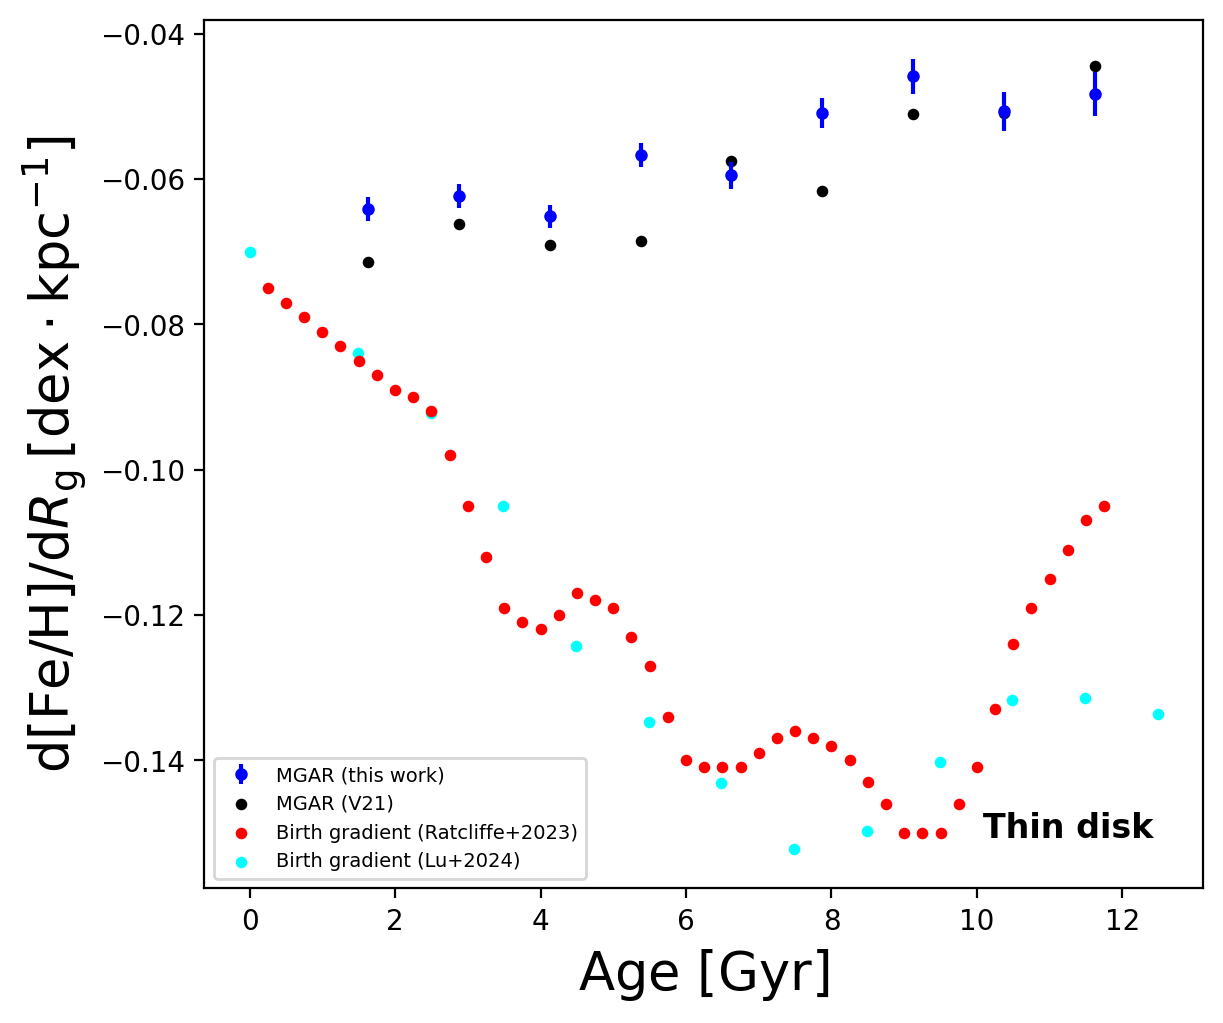

In [26]:
fig,ax=plt.subplots(1,1,figsize=(6,5),constrained_layout=True)
thiswork = ax.errorbar(age_binedge,thin_grad,yerr=thin_err, fmt='.',color='blue', ms=7)
#ax.errorbar(age_binedge,thin_grad[3],yerr=thin_err4,label='K23',fmt='.',color='blue')
V21 = ax.scatter(age_binedge,john_result0, color='black',s=10)
Ratcliffe = ax.scatter(*bridget.T,s=10,color='red',zorder=5)
#ax.errorbar(age_anders,anders[:,0],yerr=[anders[:,1], anders[:,2]],fmt='.C3',lw=1,label='Anders+2023')
Lu24 = ax.scatter(*lu.T,color='cyan',s=10)
ax.set_xlabel(age_label,fontdict=temp_fontdict)
ax.set_ylabel(grad_label,fontdict=temp_fontdict)
ax.legend([thiswork, V21, Ratcliffe, Lu24], ['MGAR (this work)', 'MGAR (V21)', 'Birth gradient (Ratcliffe+2023)', "Birth gradient (Lu+2024)"], fontsize=7,loc='lower left')
ax.text(0.95, 0.05, 'Thin disk', horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontsize=12, weight='bold')
fig.savefig("figures/compare.pdf")

# Figure 7

Caption:

We explore the MGAR with only different chemical cuts. The chemical selection in Section 2.2 is shifted by ±0.1 dex, and the MGARs of four different chemical subsets are shown in the top row.

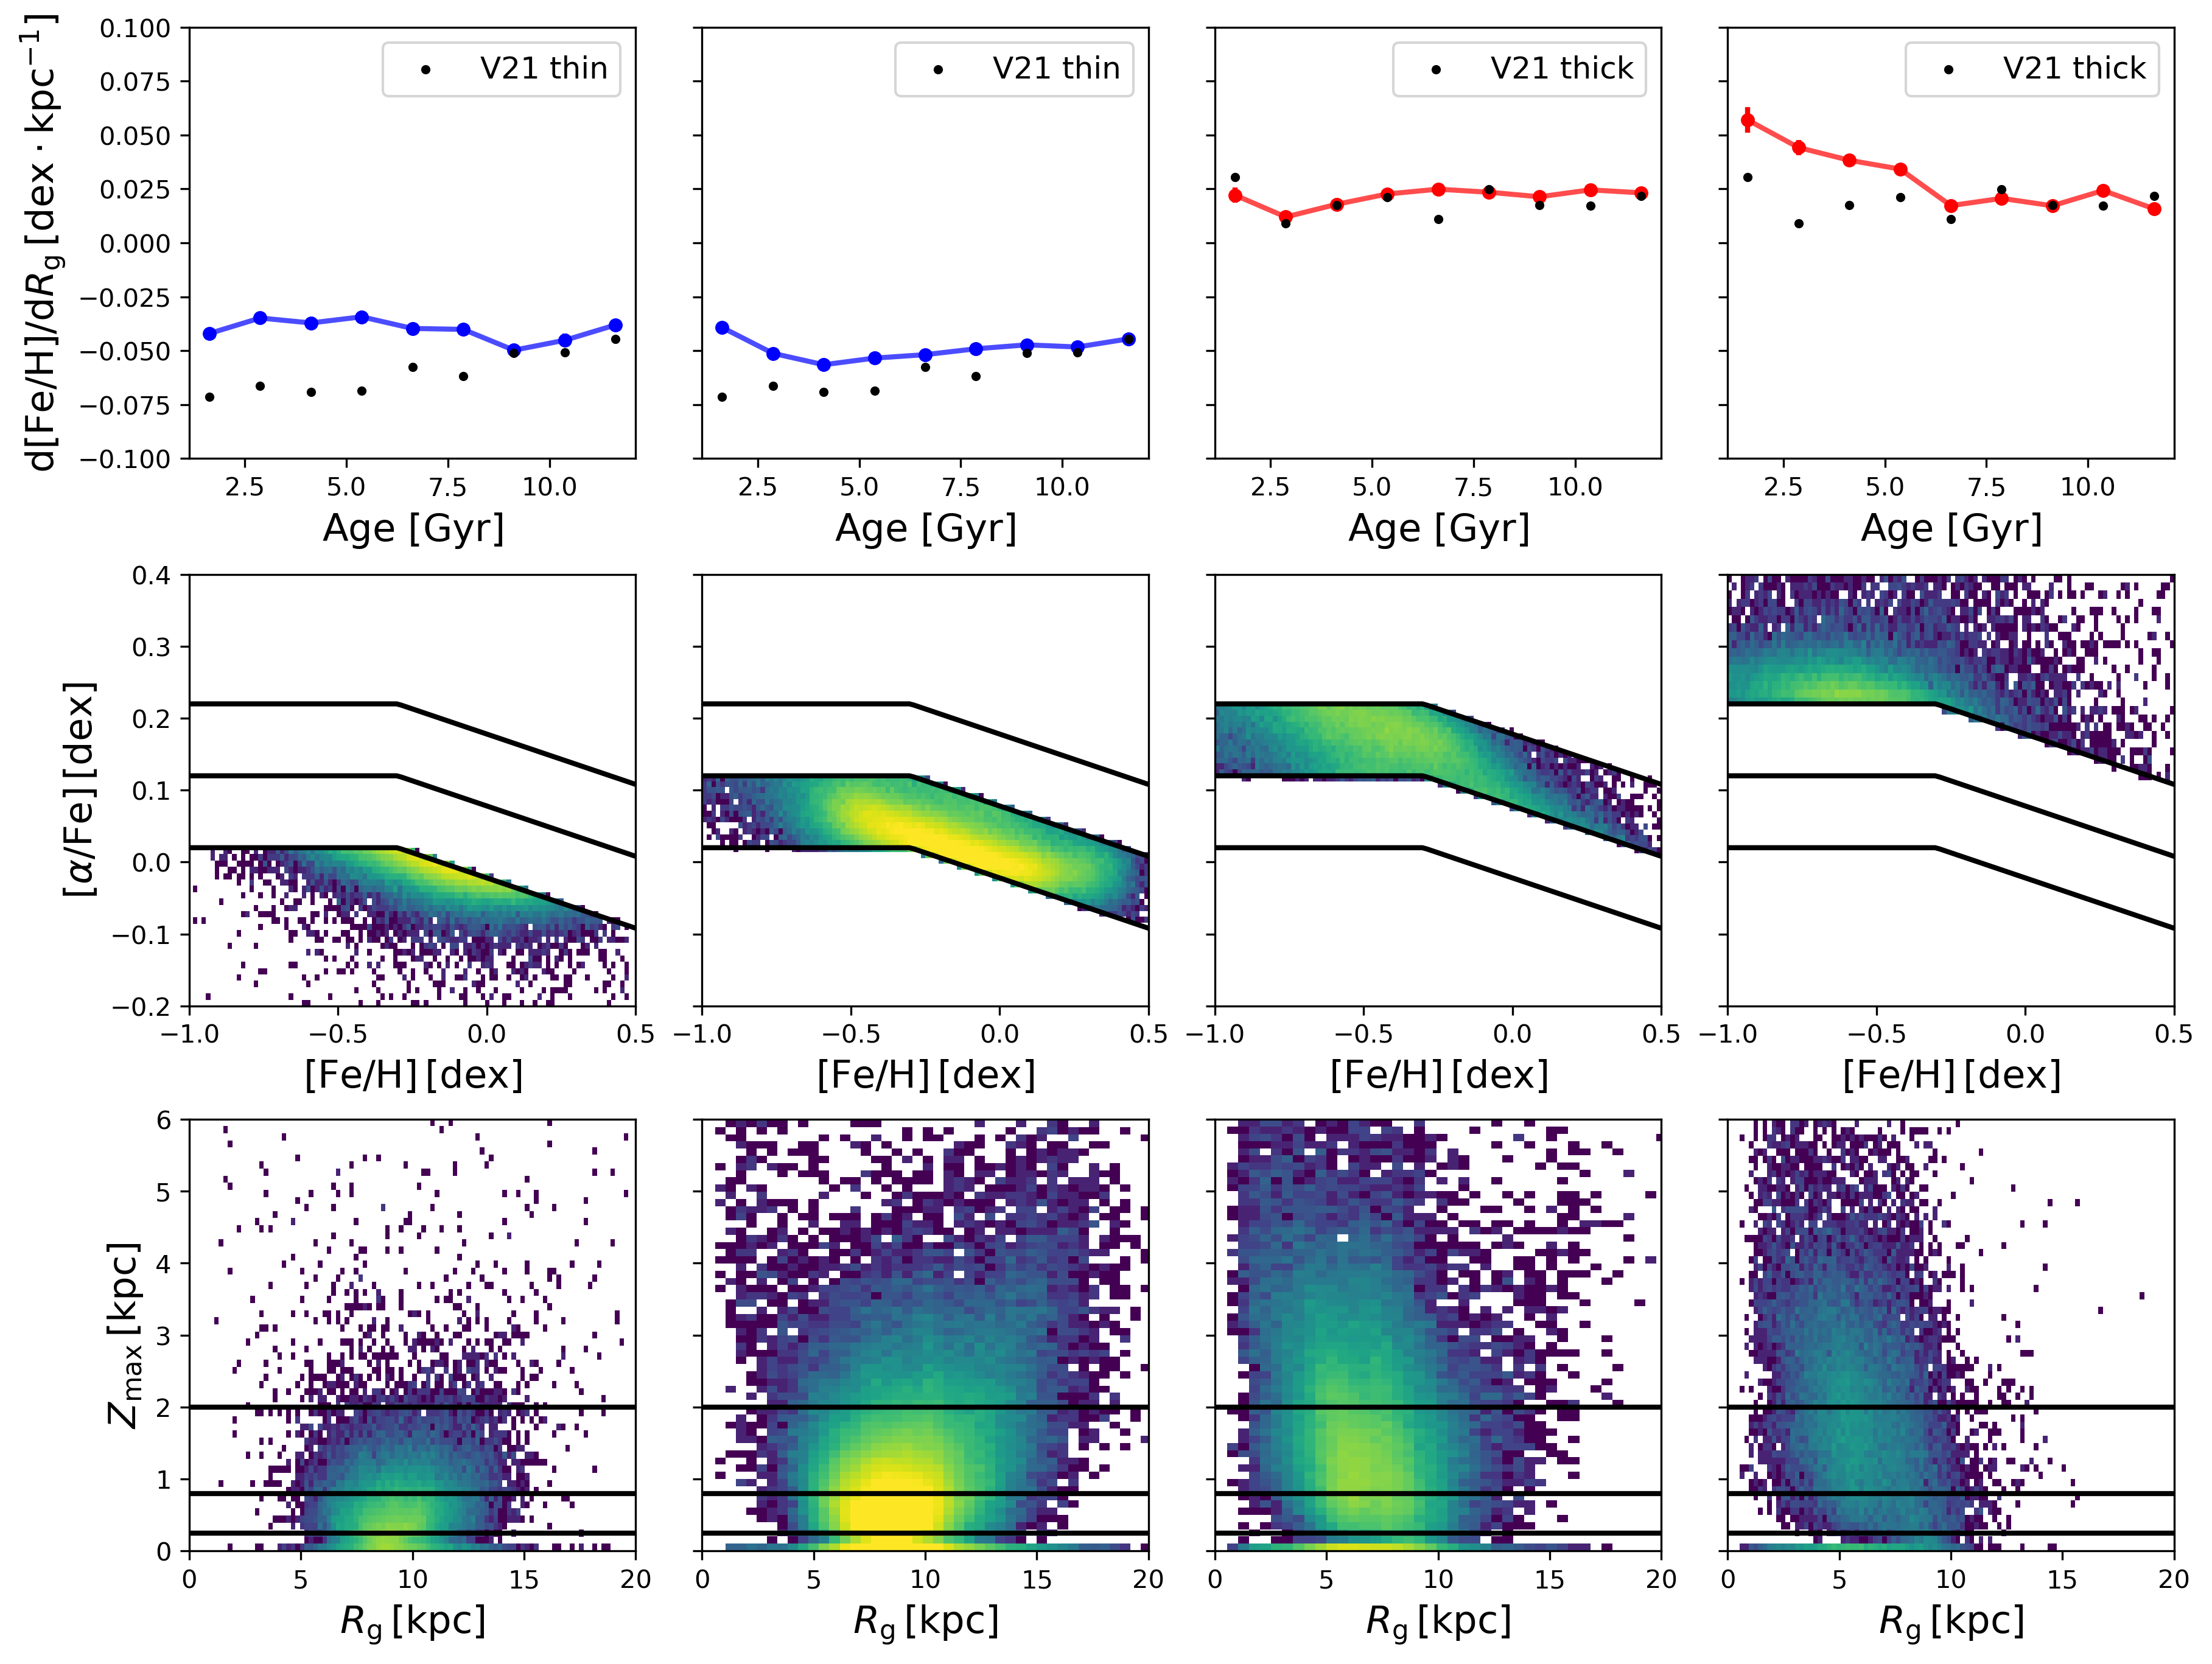

In [27]:
mpl.rcParams['figure.dpi']=300
temp_fontdict = {"fontsize": 15}
chemical_cuts = [-np.inf, -0.1, 0, 0.1, np.inf]
agebin = np.linspace(1,12.25,10,endpoint=True)
age_binedge = (agebin[:-1] + agebin[1:])/2
feh_ = np.linspace(-1, .5, 100)
z_cuts = [0, 0.25, 0.8, 2, 6]
def selection_d(feh, alphafe):
    d = alphafe - 0.12 * bool(feh < -.3) - (-0.14 * (feh+0.3) + 0.12) * bool(feh >= -.3)
    return d
def selection_d1(feh):
    if feh < -.3:
        return 0.12
    else:
        return -0.14*(feh+0.3) + 0.12
selection_d = np.vectorize(selection_d)
selection_d1 = np.vectorize(selection_d1)
alphafe_ = selection_d1(feh_)


fig, axes=plt.subplots(3, 4,figsize=(12, 9), sharey='row', constrained_layout=True)

    #def gradient_cal(data,rg_name, feh_name, age_name,erg_name=None, efeh_name=None):
for i in range(4):
    D_i = data[(selection_d(data["FEH_APOGEE"], data['AFE_APOGEE'])>chemical_cuts[i] ) & (selection_d(data["FEH_APOGEE"], data['AFE_APOGEE'])<chemical_cuts[i+1])]
    meta_gradients, _, error_meta_gra = gradient_cal(D_i)

    if i<2:
        axes[0, i].errorbar(age_binedge, meta_gradients, yerr=error_meta_gra, fmt='.',color='blue', lw=2,ms=9,)
        axes[0, i].plot(age_binedge, meta_gradients, color ='blue', lw=2, alpha=0.7)
    else:
        axes[0, i].errorbar(age_binedge, meta_gradients, yerr=error_meta_gra, fmt='.',color='red', lw=2,ms=9,)
        axes[0, i].plot(age_binedge, meta_gradients, color ='red', lw=2, alpha=0.7)
    axes[0, i].set_ylim([-0.1, .1])
    axes[0, i].set_xlabel(age_label,fontdict=temp_fontdict)
    hist2d(fig,axes[1,i],D_i['FEH_APOGEE'],D_i['AFE_APOGEE'],D_i['AFE_APOGEE'],stat='count',lognorm=True,vmin=1,vmax=6e2,ybin=25)

    axes[1, i].plot(feh_, alphafe_, color='black', linewidth=2)
    axes[1, i].plot(feh_, alphafe_ - .1, color='black', linewidth=2)
    axes[1, i].plot(feh_, alphafe_ + .1, color='black', linewidth=2)
    axes[1, i].set_ylim([-.2, .4])
    axes[1, i].set_xlim([-1, .5])
    axes[1, i].set_xlabel(feh_label,fontdict=temp_fontdict)

    if i < 2:
        hist2d(fig,axes[2,i],D_i[D_i['zmax']<10]['rg'],D_i[D_i['zmax']<10]['zmax'],D_i[D_i['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3);
        axes[0, i].scatter(age_binedge, john_result0,s=7, color='black',zorder=10,label='V21 thin')
    else:
        hist2d(fig,axes[2,i],D_i[D_i['zmax']<10]['rg'],D_i[D_i['zmax']<10]['zmax'],D_i[D_i['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3);
        axes[0, i].scatter(age_binedge, john_result1,s=7, color='black',zorder=10,label='V21 thick')
    axes[2, i].set_xlim([0, 20])
    axes[2, i].set_ylim([0, 6]);
    axes[2, i].set_xlabel(rg_label,fontdict=temp_fontdict)

    for j in range(3):
        axes[2, i].hlines(z_cuts[j+1], 0, 20, color='black', linewidth=2)
    axes[0, i].legend(fontsize=12)
axes[0, 0].set_ylabel(grad_label,fontdict=temp_fontdict)
axes[1, 0].set_ylabel(afe_label,fontdict=temp_fontdict)
axes[2, 0].set_ylabel(zmax_label,fontdict=temp_fontdict)
fig.savefig('figures/chemsubdiv.jpeg',dpi=300)

# Figure 8

Caption:

Similar to Figure 7, but here we explore the robustness of the MGAR using different Zmax cuts: (0.25, 0.8, 2, 6) kpc.

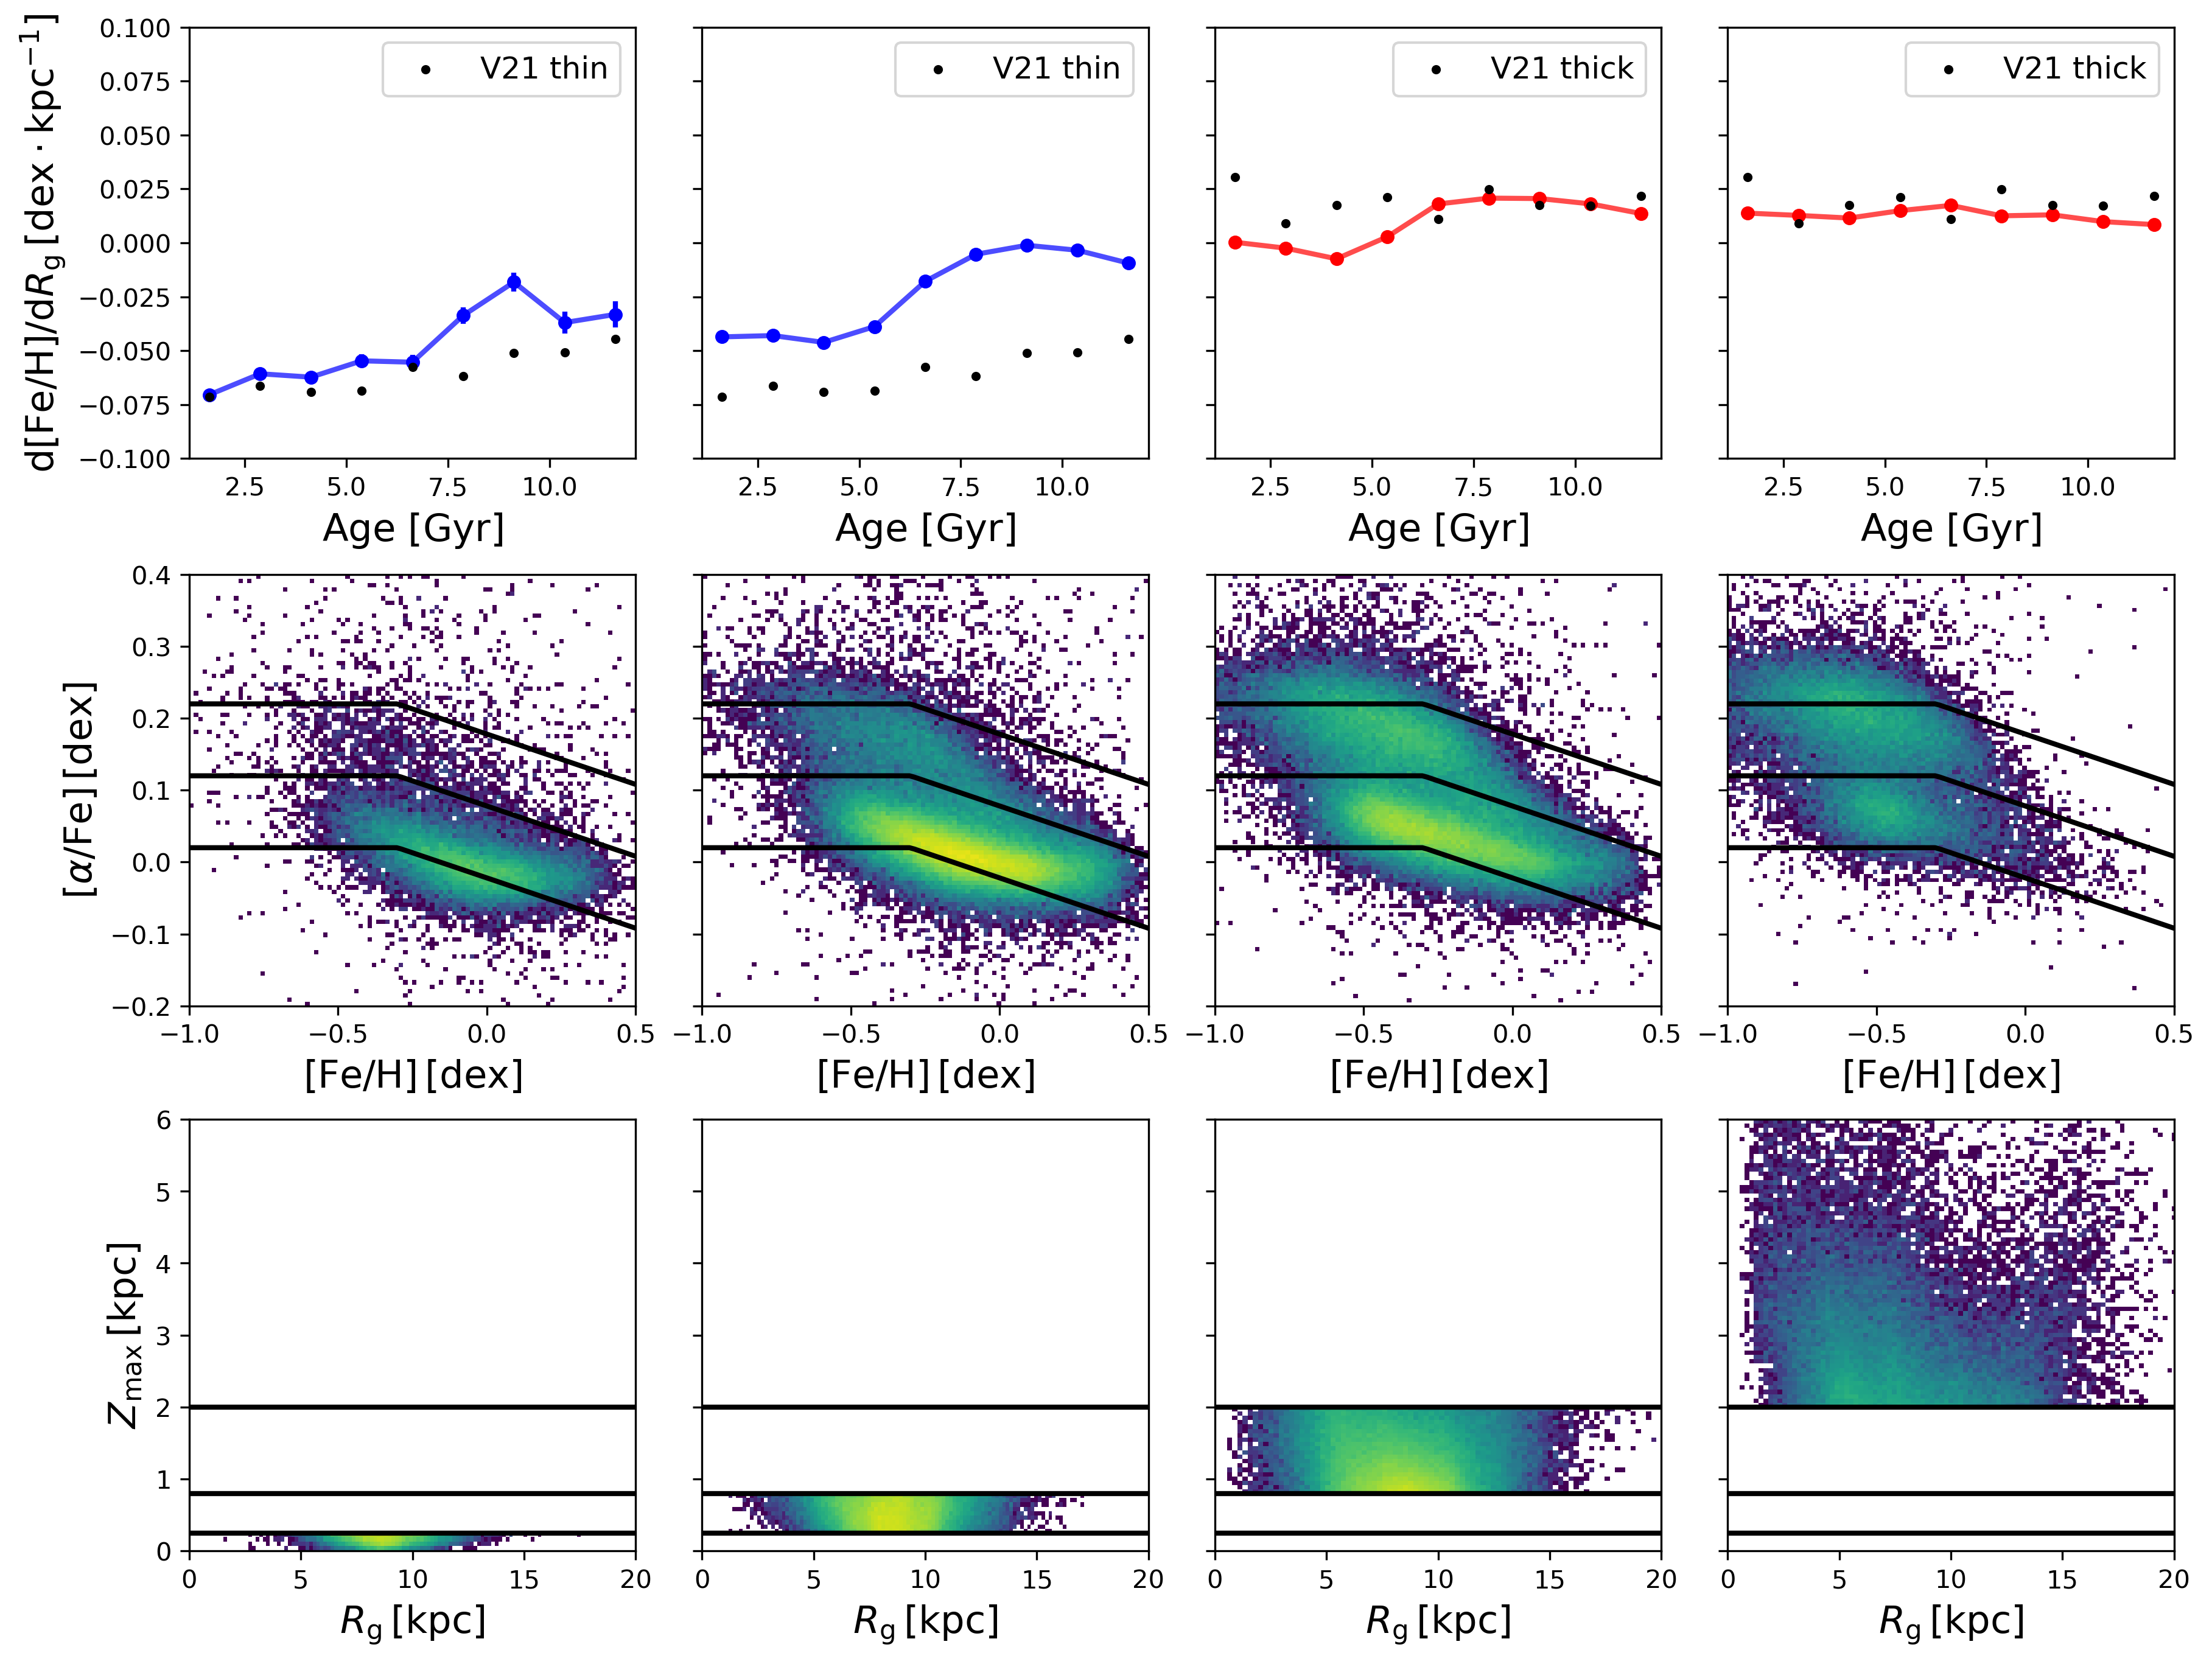

In [28]:
fig, axes=plt.subplots(3, 4,figsize=(12, 9), constrained_layout=True, sharey='row')
    #def gradient_cal(data,rg_name, feh_name, age_name,erg_name=None, efeh_name=None):
for i in range(4):
    D_i = data[(data['zmax']>z_cuts[i] ) & (data['zmax']< z_cuts[i+1])]
    meta_gradients, _, error_meta_gra = gradient_cal(D_i)
    if i<2:
        axes[0, i].errorbar(age_binedge, meta_gradients, yerr=error_meta_gra, fmt='.',color='blue', lw=2,ms=9,)
        axes[0, i].plot(age_binedge, meta_gradients, color ='blue', lw=2, alpha=0.7)
    else:
        axes[0, i].errorbar(age_binedge, meta_gradients, yerr=error_meta_gra, fmt='.',color='red', lw=2,ms=9,)
        axes[0, i].plot(age_binedge, meta_gradients, color ='red', lw=2, alpha=0.7)
    axes[0, i].set_ylim([-0.1, .1])
    axes[0, i].set_xlabel(age_label,fontdict=temp_fontdict)

    hist2d(fig,axes[1,i],D_i['FEH_APOGEE'],D_i['AFE_APOGEE'],D_i['AFE_APOGEE'],stat='count',lognorm=True,vmin=1,vmax=4e2)
    axes[1, i].plot(feh_, alphafe_, color='black', linewidth=2)
    axes[1, i].plot(feh_, alphafe_ - .1, color='black', linewidth=2)
    axes[1, i].plot(feh_, alphafe_ + .1, color='black', linewidth=2)
    axes[1, i].set_ylim([-.2, .4])
    axes[1, i].set_xlim([-1, .5])
    axes[1, i].set_xlabel(feh_label,fontdict=temp_fontdict)

    if i < 2:
        hist2d(fig,axes[2,i],D_i[D_i['zmax']<10]['rg'],D_i[D_i['zmax']<10]['zmax'],D_i[D_i['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3,ybin=int((z_cuts[i+1]-z_cuts[i])/6*100));
        axes[0, i].scatter(age_binedge, john_result0,s=7, color='black',zorder=10,label='V21 thin')
    else:
        hist2d(fig,axes[2,i],D_i[D_i['zmax']<10]['rg'],D_i[D_i['zmax']<10]['zmax'],D_i[D_i['zmax']<10]['zmax'],stat='count',lognorm=True,vmin=1,vmax=1e3,ybin=int((z_cuts[i+1]-z_cuts[i])/6*100));
        axes[0, i].scatter(age_binedge, john_result1,s=7, color='black',zorder=10,label='V21 thick')
    axes[2, i].set_xlim([0, 20])
    axes[2, i].set_ylim([0, 6]);
    axes[2, i].set_xlabel(rg_label, fontdict=temp_fontdict)

    for j in range(3):
        axes[2, i].hlines(z_cuts[j+1], 0, 20, color='black', linewidth=2)
    axes[0, i].legend(fontsize=12)
axes[0, 0].set_ylabel(grad_label,fontdict=temp_fontdict)
axes[1, 0].set_ylabel(afe_label,fontdict=temp_fontdict)
axes[2, 0].set_ylabel(zmax_label,fontdict=temp_fontdict)
fig.savefig('figures/zmaxsubdiv.jpeg',dpi=300)

# Figure 9

Caption:

Robustness test of different orbital calculation setups: three potentials in galpy (McMillan17, MWPotential2014, Irrgang13I, first row), R⊙s (8.27 kpc, 7.0 kpc, 9.5 kpc, second row), and v⊙s (236 km/s, 260 km/s, 200 km/s, third row). The canonical results in the main text use Φ =MWPotential2014, R⊙ = 8.27 kpc, and v⊙ = 236 km/s. These tests show that gradients are primarily affected by R⊙ and v⊙ in the thin disk, though the flattening trend remains invariant.

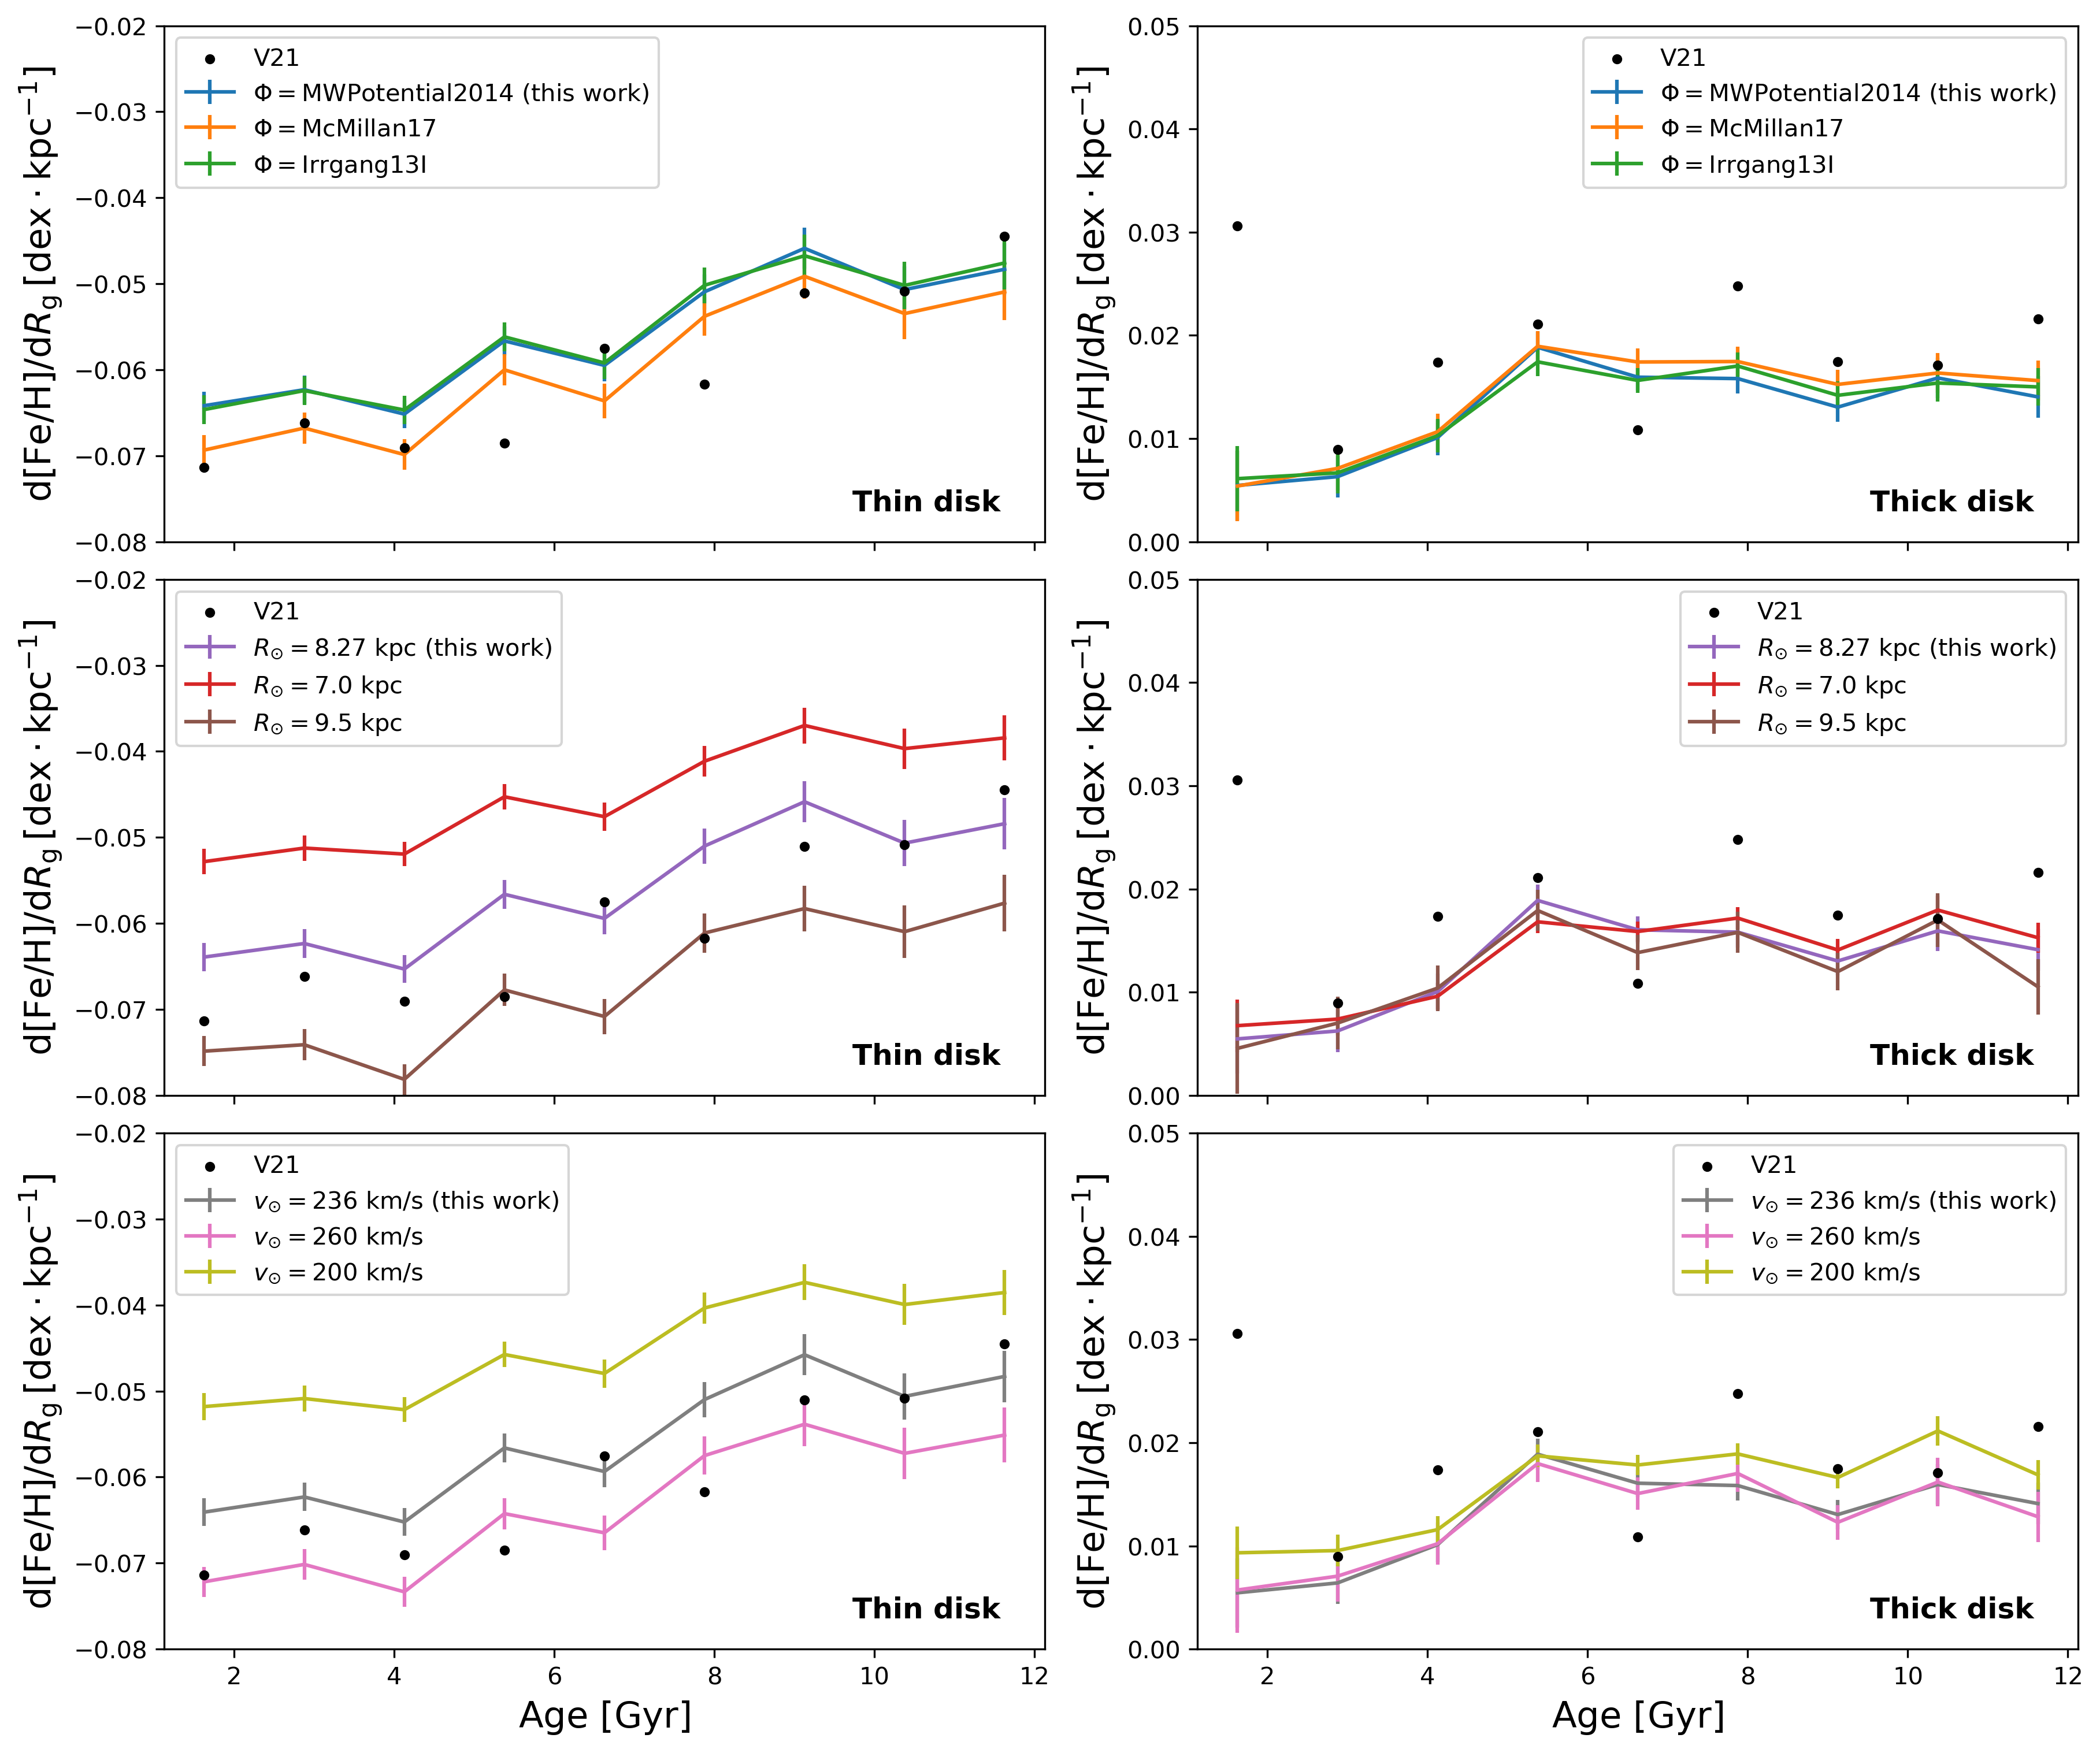

In [29]:
thin_grad_ = {'pots':[],'ros':[],'vos':[]}
thick_grad_ = {'pots':[],'ros':[],'vos':[]}
thin_err_ = {'pots':[],'ros':[],'vos':[]}
thick_err_ = {'pots':[],'ros':[],'vos':[]}
data_ = [thin_grad_, thin_err_, thick_grad_, thick_err_]
data_name = ['thin_meta_grad', 'thin_err', 'thick_meta_grad', 'thick_err']
keys = ['pots','ros','vos']
for i in range(9):
    for j in range(4):
        data_[j][keys[i//3]].append(np.load(f'other_pot/{data_name[j]}{i}.npy'))
temp_fontdict = {'size': 15}
john_result0 = [-0.07136605331685393,-0.06618091552921639,-0.06903697210837685,-0.06850242530104698,-0.0575328258962722,-0.061708978692798754,-0.05103489691764598,-0.050863061235406334,-0.04449164799032207]
john_result1 = [0.030581896548247063,0.008961716331309445,0.017367009544394674,0.021081516069632263,0.010867124228798833,0.02477353965786783,0.017448674640475975,0.01710349947548126,0.021578666805793047]
fig, axes = plt.subplots(3,2,figsize=(12,10),sharex=True,constrained_layout=True)
axes = axes.T
pots = ['MWPotential2014 (this work)','McMillan17', 'Irrgang13I']
ros = ['7.0 kpc','8.27 kpc (this work)','9.5 kpc']
vos = ['260 km/s', '236 km/s (this work)', '200 km/s']
labs = [pots,ros,vos]
keys2 = ['$\\Phi=$','$R_{\\odot}=$','$v_{\\odot}=$']



for j in range(3):
    axes[0,j].text(0.95, 0.05, 'Thin disk', horizontalalignment='right',verticalalignment='bottom', transform=axes[0,j].transAxes,fontsize=12, weight='bold')
    axes[1,j].text(0.95, 0.05, 'Thick disk', horizontalalignment='right',verticalalignment='bottom', transform=axes[1,j].transAxes,fontsize=12, weight='bold')
    axes[1,j].set_ylim(0,0.05)
    axes[0,j].set_ylim(-0.08,-0.02)
    axes[0,j].scatter(age_binedge, john_result0,s=10,color='black',zorder=10,label='V21')
    axes[1,j].scatter(age_binedge, john_result1,s=10,color='black',zorder=10,label='V21')
    if j >0:
        for i in [1, 0, 2]:
            axes[0,j].errorbar(age_binedge,data_[0][keys[j]][i],yerr=data_[1][keys[j]][i],label=f'{keys2[j]}{labs[j][i]}', color=f'C{i+j*3}')
            axes[1,j].errorbar(age_binedge,data_[2][keys[j]][i],yerr=data_[3][keys[j]][i],label=f'{keys2[j]}{labs[j][i]}', color=f'C{i+j*3}')
    else:
        for i in range(3):
            axes[0,j].errorbar(age_binedge,data_[0][keys[j]][i],yerr=data_[1][keys[j]][i],label=f'{keys2[j]}{labs[j][i]}', color=f'C{i+j*3}')
            axes[1,j].errorbar(age_binedge,data_[2][keys[j]][i],yerr=data_[3][keys[j]][i],label=f'{keys2[j]}{labs[j][i]}', color=f'C{i+j*3}')
    axes[0,j].legend(loc='upper left')
    axes[1,j].legend(loc='upper right')
for idx,ax in enumerate(axes.flatten()):
    if (idx+1)%3==0:
        ax.set_xlabel(age_label,fontdict=temp_fontdict)
    ax.set_ylabel(grad_label,fontdict=temp_fontdict)
fig.savefig("figures/tests.pdf")

# Figure 10

Caption:

Bayesian approach incorporating uncertainties in [Fe/H], Rg and τ . The left panel shows blue dots for results in the main text, black for V21, and forest green for the Bayesian model. The right panel shows red for main text results, black for V21, and gold for the Bayesian model. The shaded regions represent the 98% highest density intervals (HDI) corresponding to each fitted line. Priors for all shades are the same: slope ∼ N (0, 22) and intercept ∼ N (0, 22). Solid line fitting model: gradient ∼ N (intercept + slope × age bin center, ϵ2), where ϵ ∼ HalfCauchy(β = 5).

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, eps]


Output()

Sampling 4 chains for 1_000 tune and 4_000 draw iterations (4_000 + 16_000 draws total) took 9 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.


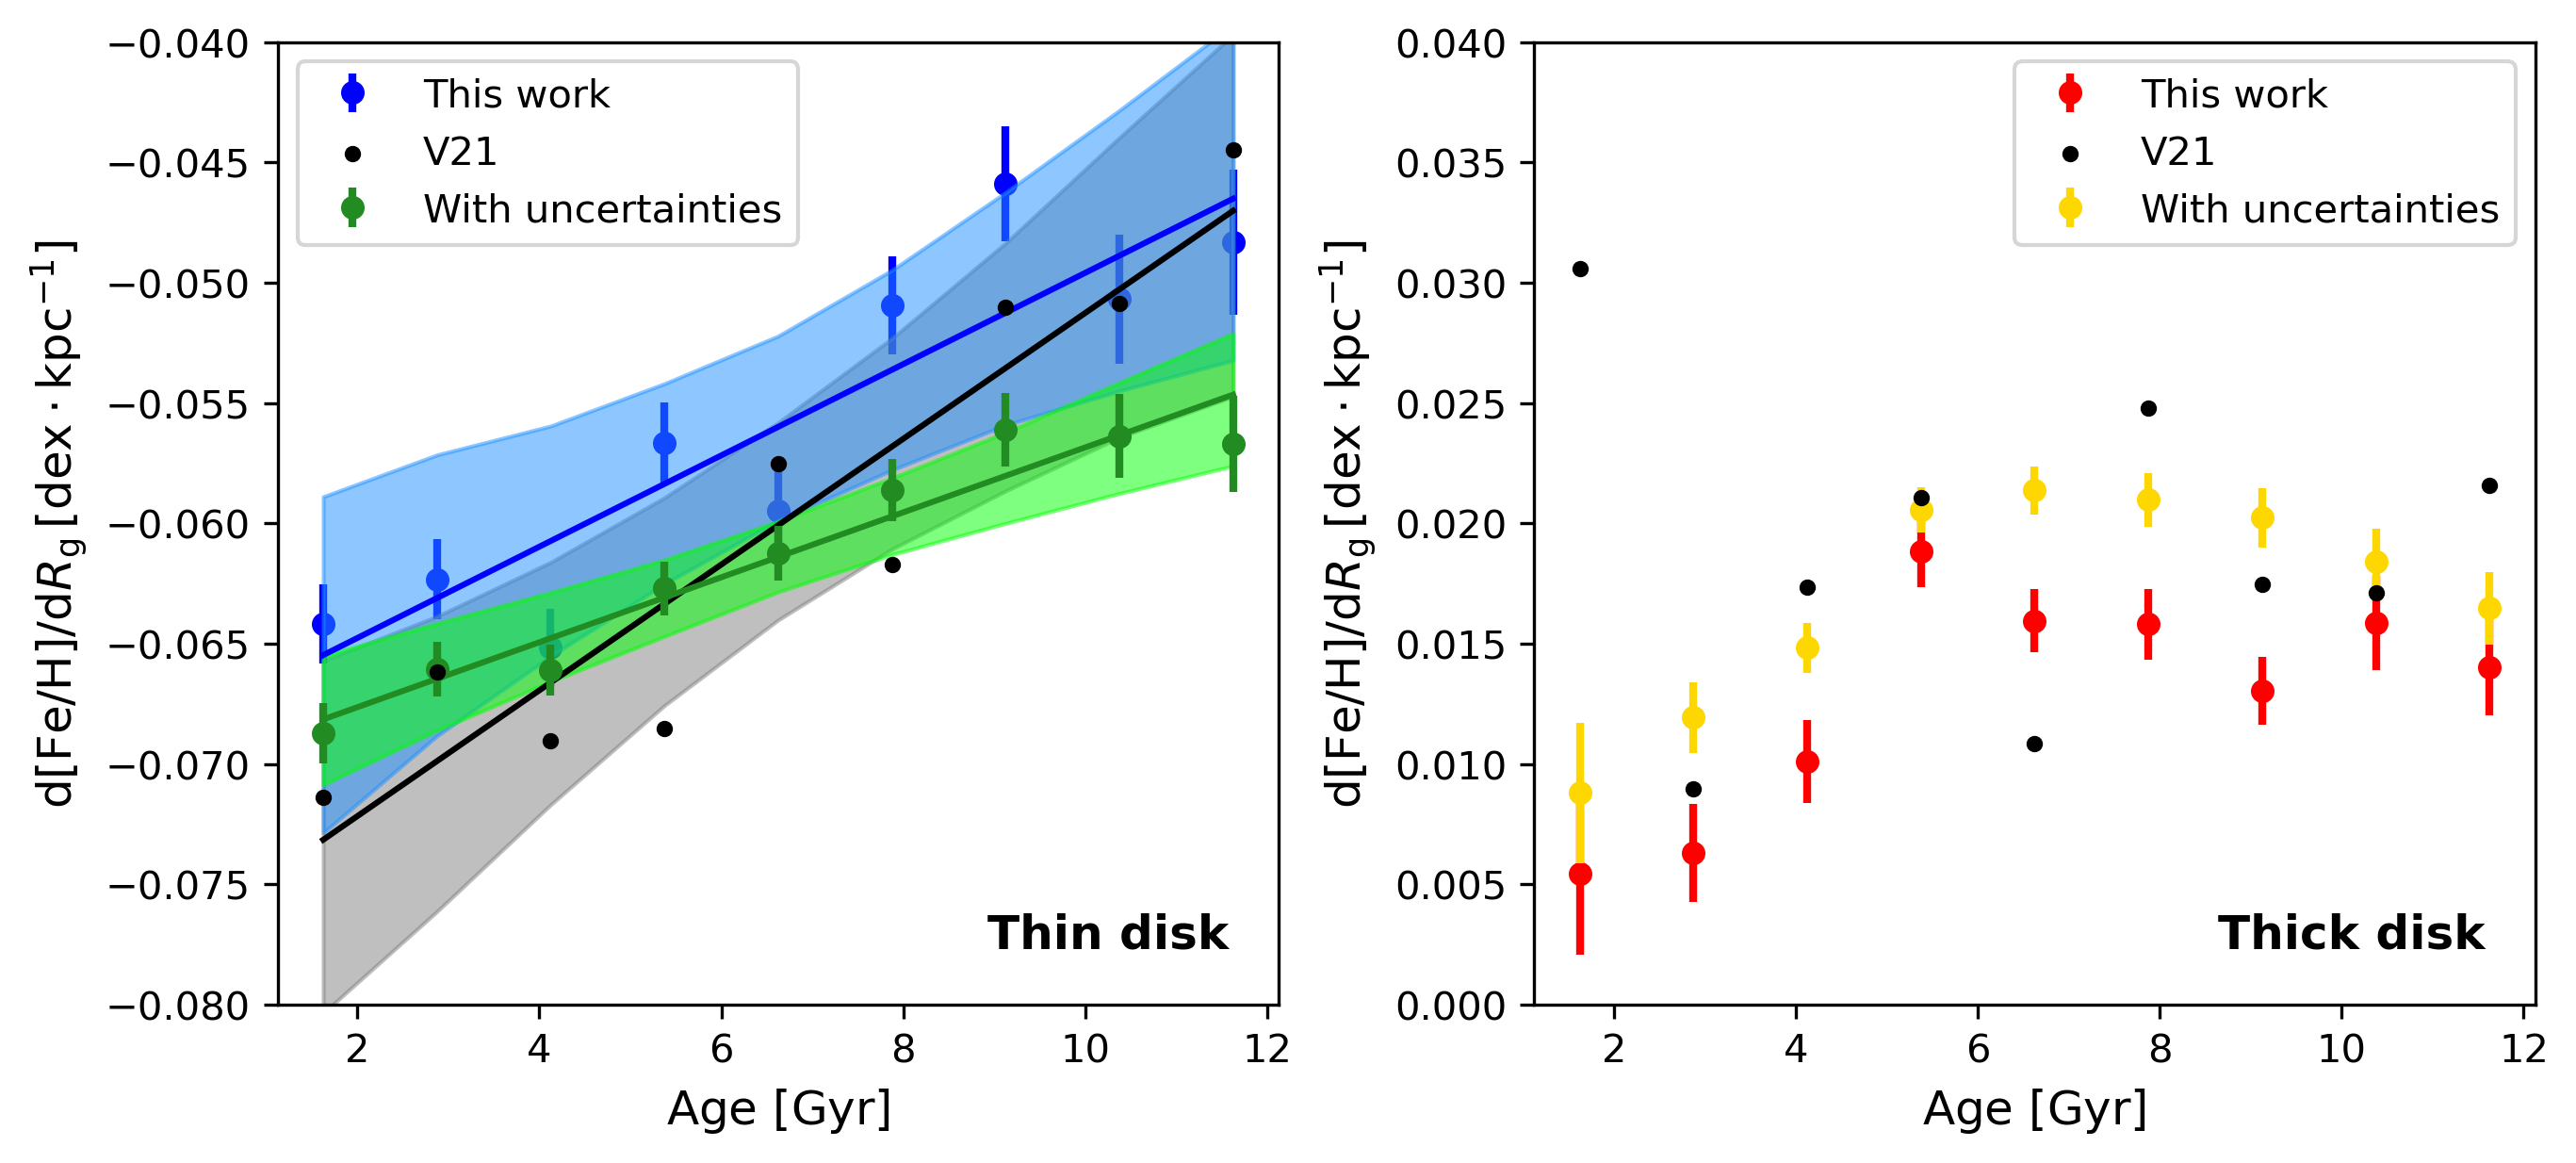

In [30]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 4),constrained_layout=True)

thiswork_thin = ax1.errorbar(age_binedge,thin_grad,yerr=thin_err,fmt='.b',lw=2,ms=10,label='This work', zorder=-5)
thiswork_thick = ax2.errorbar(age_binedge,thick_grad,yerr=thick_err,fmt='.r',lw=2,ms=10,label='This work', zorder=-5)

thin_hdi =np.zeros((9, 2))
thin_median = np.zeros(9)
thin_std = np.zeros(9)
thick_hdi = np.zeros((9, 2))
thick_median = np.zeros(9)
thick_std = np.zeros(9)
for i in range(9):
    thin_ = az.from_json(f"./traces/thin_{i}.json")
    thin_ = az.extract(thin_, var_names=['grad'], combined=True).values
    thin_median[i] = np.median(thin_)
    thin_std[i] = np.std(thin_)
    #thin_hdi[i, :] = az.hdi(thin_, hdi_prob=0.98)
    thick_ = az.from_json(f"./traces/thick_{i}.json")
    thick_ = az.extract(thick_, var_names=['grad'], combined=True).values
    thick_median[i] = np.median(thick_)
    thick_std[i] = np.std(thick_)
    #thick_hdi[i, :] = az.hdi(thick_, hdi_prob=0.98)

uncertain_thick = ax2.errorbar(age_binedge, thick_median, yerr=thick_std, fmt='.', color='gold', lw=2, ms=10, label='With uncertainties')
#az.plot_hdi(age_binedge, hdi_data=thick_hdi, ax=ax2, fill_kwargs={'alpha': 0.5, 'color': 'yellow'})
V21_thick = ax2.scatter(age_binedge, john_result1, color='black', s=10, zorder=10, label='V21')
ax1.set_ylim(-0.08, -0.04)
ax2.set_ylim(0, 0.04)
ax2.set_xlabel(age_label, fontdict=label_font)
ax2.set_ylabel(grad_label, fontdict=label_font);



a_m = np.median(trace_john.posterior['a'].values) 
b_m = np.median(trace_john.posterior['b'].values)
ax1.plot(age_binedge, a_m + b_m * age_binedge, c='black') 
az.plot_hdi(age_binedge, trace_john.posterior['mu'], color='grey', hdi_prob=0.98, ax=ax1, smooth=False, fill_kwargs={ 'alpha': 0.5,'edgecolors': 'none'})
 
a_m = np.median(trace_thin.posterior['a'].values)
b_m = np.median(trace_thin.posterior['b'].values)
ax1.plot(age_binedge, a_m + b_m * age_binedge, c='blue')
az.plot_hdi(age_binedge, trace_thin.posterior['mu'], color='dodgerblue', hdi_prob=0.98, ax=ax1, smooth=False, fill_kwargs={'alpha': 0.5, 'edgecolors': 'none'});

uncertain_thin = ax1.errorbar(age_binedge, thin_median, yerr=thin_std, fmt='.', color='forestgreen', lw=2, ms=10, label='With uncertainties')
az.plot_hdi(age_binedge, hdi_data=thin_hdi, ax=ax1, fill_kwargs={'alpha': 0.5, 'color': 'lime'})
V21_thin = ax1.scatter(age_binedge, john_result0, color='black', s=10, zorder=10, label='V21')

ax1.set_xlabel(age_label, fontdict=label_font)
ax1.set_ylabel(grad_label, fontdict=label_font);
ax1.text(0.95, 0.05, 'Thin disk', horizontalalignment='right',verticalalignment='bottom', transform=ax1.transAxes,fontsize=12, weight='bold')
ax2.text(0.95, 0.05, 'Thick disk', horizontalalignment='right',verticalalignment='bottom', transform=ax2.transAxes,fontsize=12, weight='bold')

with pm.Model() as model_thin:
    a = pm.Normal('a', mu=0, sigma=2) 
    b = pm.Normal('b', mu=0, sigma=2)
    eps = pm.HalfCauchy('eps', 5)
    mu = pm.Deterministic('mu', a + b * age_binedge)
    y_pred = pm.Normal('y_pred', mu=mu, sigma=eps, observed=thin_median) 
    uncertainties_thin = pm.sample(4000, tune=1000)

a_m = np.median(uncertainties_thin.posterior['a'].values)
b_m = np.median(uncertainties_thin.posterior['b'].values)
ax1.plot(age_binedge, a_m + b_m * age_binedge, c='forestgreen')
az.plot_hdi(age_binedge, uncertainties_thin.posterior['mu'], color='lime', hdi_prob=0.98, ax=ax1, smooth=False, fill_kwargs={'alpha': 0.5, 'edgecolors': 'none'});

ax1.legend([thiswork_thin, V21_thin, uncertain_thin], ["This work", "V21", "With uncertainties"], loc='upper left')
ax2.legend([thiswork_thick, V21_thick, uncertain_thick], ["This work", "V21", "With uncertainties"]);
fig.savefig("figures/with_uncertainties.pdf")